<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [607]:
pip install gdown -q

Note: you may need to restart the kernel to use updated packages.


In [608]:
import pandas as pd
import numpy as np

In [646]:
import gdown

url = 'https://drive.google.com/uc?id=1Jt_qbTvrAIJ516Rg-QW2vzpFkbdF0ezm'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Jt_qbTvrAIJ516Rg-QW2vzpFkbdF0ezm
From (redirected): https://drive.google.com/uc?id=1Jt_qbTvrAIJ516Rg-QW2vzpFkbdF0ezm&confirm=t&uuid=6dca707d-5427-4f22-a4c0-ed6f9e312028
To: e:\Project\HSE\ML\corse\Data.zip
100%|██████████| 299M/299M [00:39<00:00, 7.64MB/s]


'Data.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [687]:
import pandas as pd

# Загрузка данных из CSV
campaing_data = pd.read_csv("UpliftData/CAMPAINGS.csv")
contract_data = pd.read_csv("UpliftData/CONTRACTS_FINAL.csv")
scoring_user_data = pd.read_csv("UpliftData/AGGS_FINAL.csv")
user_campaing_delivery_data = pd.read_csv("UpliftData/PEOPLE_IN_CAMPAINGS_FINAL.csv")

user_campaing_delivery_data['report_dt'] = pd.to_datetime('2024-11-01')
user_campaing_delivery_data["prediction_dt"] = user_campaing_delivery_data["report_dt"] + pd.DateOffset(months=-1)
user_campaing_delivery_data["prediction_dt"] = user_campaing_delivery_data["prediction_dt"] - pd.Timedelta(days=1)

# Шаг 1: Замена "unknown" на NaN в delivery_date
user_campaing_delivery_data['delivery_date'] = user_campaing_delivery_data['delivery_date'].replace('unknown', np.nan)

# Шаг 2: Приведение типов данных
# Преобразование delivery_date и contract_date в datetime
user_campaing_delivery_data['delivery_date'] = pd.to_datetime(user_campaing_delivery_data['delivery_date'], errors='coerce')
contract_data['contract_date'] = pd.to_datetime(contract_data['contract_date'], errors='coerce')

# Преобразование user_id и t_flag в int
user_campaing_delivery_data['user_id'] = user_campaing_delivery_data['user_id'].astype(int)
user_campaing_delivery_data['t_flag'] = user_campaing_delivery_data['t_flag'].astype(int)

# Шаг 3: Создаем подзапрос для контрактов (минимальная дата контракта для каждого пользователя)
min_contract_dates = contract_data.groupby('user_id')['contract_date'].min().reset_index()

# Шаг 4: Объединяем кампании с пользователями (INNER JOIN)
merged = pd.merge(
    campaing_data,
    user_campaing_delivery_data,
    on='campaing_id',
    how='inner'
)

# Шаг 5: Добавляем информацию о контрактах (LEFT JOIN)
result = pd.merge(
    merged,
    min_contract_dates,
    on='user_id',
    how='left'
)

# Шаг 6: Выбираем нужные колонки (аналог SELECT)
final_result = result[['channel', 'user_id', 't_flag', 'report_dt', 'prediction_dt', 'delivery_date', 'contract_date']]

# Шаг 7: Сортировка (если нужна)
final_result = final_result.sort_values(by=['user_id', 'delivery_date'])


In [688]:
final_result.count()

channel          520000
user_id          520000
t_flag           520000
report_dt        520000
prediction_dt    520000
delivery_date    260000
contract_date    337635
dtype: int64

In [690]:
final_result.dtypes

channel                  object
user_id                   int32
t_flag                    int32
report_dt        datetime64[ns]
prediction_dt    datetime64[ns]
delivery_date    datetime64[ns]
contract_date    datetime64[ns]
dtype: object

In [691]:
final_result["target"] = 0  # default = 0
final_result.loc[
    (final_result["t_flag"] == 1) &
    (final_result["contract_date"].notna()) &
    (final_result["contract_date"] <= final_result["delivery_date"] + pd.Timedelta(weeks=2)),
    "target"
] = 1

final_result.loc[
    (final_result["t_flag"] == 0) &
    (final_result["contract_date"].notna()) &
    (final_result["contract_date"] <= final_result["report_dt"] + pd.Timedelta(weeks=3)),
    "target"
] = 1

In [693]:
final_result.groupby(['channel','t_flag'])['target'].count()

channel    t_flag
banner     0         60000
           1         60000
other_ads  0         60000
           1         60000
push       0         80000
           1         80000
sms        0         60000
           1         60000
Name: target, dtype: int64

In [696]:
final_result.groupby(['channel','t_flag'])['target'].sum()

channel    t_flag
banner     0         24044
           1         41265
other_ads  0         24044
           1         42136
push       0         16172
           1         54962
sms        0         41095
           1         23917
Name: target, dtype: int64

In [697]:
import numpy as np

def bootstrap_diff(data, n_iterations=1000):
    """
    Функция для бутстрэп-анализа разницы в конверсии (target) между группами t_flag=1 и t_flag=0.
    Возвращает 95% доверительный интервал и среднюю разницу.
    """
    diffs = []
    for _ in range(n_iterations):
        sample = data.sample(frac=1, replace=True)
        treated_rate = sample[sample['t_flag'] == 1]['target'].mean()
        control_rate = sample[sample['t_flag'] == 0]['target'].mean()
        diffs.append(treated_rate - control_rate)
    ci = np.percentile(diffs, [2.5, 97.5])
    return ci, np.mean(diffs)

# Получаем список уникальных каналов
channels = final_result['channel'].unique()

# Проводим бутстрэп-анализ для каждого канала
for channel in channels:
    channel_data = final_result[final_result['channel'] == channel]
    ci, mean_diff = bootstrap_diff(channel_data)
    print(f"\n=== Результаты бутстрэп-анализа для канала '{channel}' ===")
    print("Средняя разница в конверсии (target) между группами:", mean_diff)
    print("95% доверительный интервал:", ci)



=== Результаты бутстрэп-анализа для канала 'push' ===
Средняя разница в конверсии (target) между группами: 0.4848832650194181
95% доверительный интервал: [0.48041194 0.4888879 ]

=== Результаты бутстрэп-анализа для канала 'sms' ===
Средняя разница в конверсии (target) между группами: -0.28621449029634916
95% доверительный интервал: [-0.29162142 -0.28040493]

=== Результаты бутстрэп-анализа для канала 'other_ads' ===
Средняя разница в конверсии (target) между группами: 0.30143312118403115
95% доверительный интервал: [0.29595994 0.30688001]

=== Результаты бутстрэп-анализа для канала 'banner' ===
Средняя разница в конверсии (target) между группами: 0.28697811468609413
95% доверительный интервал: [0.28164479 0.29248952]


In [698]:
import numpy as np
import pandas as pd

# Предполагаем, что DataFrame final_result уже сформирован и содержит колонки:
# 'channel', 'user_id', 't_flag', 'report_dt', 'prediction_month', 'delivery_date', 'contract_date', 'target'
# Если колонки 'target' ещё нет, её необходимо рассчитать согласно правилам.

# Пример анализа для каждого канала (кампании)
channels = final_result['channel'].unique()

for channel in channels:
    channel_data = final_result[final_result['channel'] == channel]

    # Разбиваем на группы по t_flag
    treatment_data = channel_data[channel_data['t_flag'] == 1]
    control_data = channel_data[channel_data['t_flag'] == 0]

    treatment_count = treatment_data.shape[0]
    control_count = control_data.shape[0]

    print(f"\n=== Анализ для канала: '{channel}' ===")
    print(f"Количество тестовой группы (t_flag=1): {treatment_count}")
    print(f"Количество контрольной группы (t_flag=0): {control_count}")

    # Проверка: если одна из групп пуста, данные некорректны для моделирования
    if treatment_count == 0 or control_count == 0:
        print(f"Данные для канала '{channel}' некорректны: одна из групп пуста. Моделирование не проводится.")
        continue

    # Проверяем, что в колонке 'target' содержатся только значения 0 и 1 (NaN допустимы)
    unique_targets = channel_data['target'].dropna().unique()
    if not set(unique_targets).issubset({0, 1}):
        print(f"Данные для канала '{channel}' некорректны: обнаружены недопустимые значения в 'target' -> {unique_targets}.")
        print("Моделирование не проводится.")
        continue

    # Рассчитываем среднее значение таргета для тестовой и контрольной групп (игнорируя NaN)
    treatment_mean = treatment_data['target'].dropna().mean()
    control_mean = control_data['target'].dropna().mean()
    uplift = treatment_mean - control_mean

    print(f"Среднее значение таргета в тестовой группе (t_flag=1): {treatment_mean:.4f}")
    print(f"Среднее значение таргета в контрольной группе (t_flag=0): {control_mean:.4f}")
    print(f"Uplift (тестовая минус контрольная): {uplift:.4f}")



=== Анализ для канала: 'push' ===
Количество тестовой группы (t_flag=1): 80000
Количество контрольной группы (t_flag=0): 80000
Среднее значение таргета в тестовой группе (t_flag=1): 0.6870
Среднее значение таргета в контрольной группе (t_flag=0): 0.2021
Uplift (тестовая минус контрольная): 0.4849

=== Анализ для канала: 'sms' ===
Количество тестовой группы (t_flag=1): 60000
Количество контрольной группы (t_flag=0): 60000
Среднее значение таргета в тестовой группе (t_flag=1): 0.3986
Среднее значение таргета в контрольной группе (t_flag=0): 0.6849
Uplift (тестовая минус контрольная): -0.2863

=== Анализ для канала: 'other_ads' ===
Количество тестовой группы (t_flag=1): 60000
Количество контрольной группы (t_flag=0): 60000
Среднее значение таргета в тестовой группе (t_flag=1): 0.7023
Среднее значение таргета в контрольной группе (t_flag=0): 0.4007
Uplift (тестовая минус контрольная): 0.3015

=== Анализ для канала: 'banner' ===
Количество тестовой группы (t_flag=1): 60000
Количество контр

## Конверсия (отношение суммы таргета к числу пользователей):

# banner

Контроль: 24 044 / 60 000 ≈ 40,1%

Тест: 41 265 / 60 000 ≈ 68,8%

# other_ads

Контроль: 24 044 / 60 000 ≈ 40,1%

Тест: 42 136 / 60 000 ≈ 70,2%

# push

Контроль: 16 172 / 80 000 ≈ 20,2%

Тест: 54 962 / 80 000 ≈ 68,7%

# sms

Контроль: 41 095 / 60 000 ≈ 68,5%

Тест: 42 096 / 60 000 ≈ 70,2%

## проблемы и сложности в данных

# Неоднородность базовых групп:

Размеры выборок: Канал push имеет большее количество пользователей (80 000) по сравнению с остальными (60 000). Это может влиять на статистическую значимость различий.

Базовая конверсия: Контрольная группа для push имеет гораздо более низкую конверсию (≈20%), в то время как для других каналов — 40–68%. Это может указывать как на особенности сегмента, так и на потенциальные проблемы в сборе или сегментации данных.

# Возможное смещение сегментов:

Пользователи, получающие push, возможно, отличаются по поведению или характеристикам от пользователей, получающих, например, sms. Необходимо проверить, не содержится ли в данных систематической разницы, которая может привести к искажённой оценке эффекта.

# Очистка и нормализация:

Обязательно заменить все значения «unknown» на NaN и корректно привести типы данных для дат.
Проверить наличие дубликатов и аномалий в выборках.

#Сегментация пользователей:

Провести дополнительный анализ сегментов пользователей по каждому каналу, чтобы убедиться, что группы сравнимы по базовым характеристикам.
При необходимости провести корректировку (например, с использованием propensity score matching).

# Учет временных лагов:

Проверить корректность расчёта таргета с учётом временного лага (агрегаты за один месяц → прогноз таргета на два месяца вперёд).

# Статистическая корректировка:

Использовать бутстрэп или другие методы для проверки значимости разницы между контрольными и тестовыми группами.

# Наиболее эффективная кампания — push:

Lift ≈ 3.40 свидетельствует о том, что пользователи, получающие push-уведомления, в 3.4 раза чаще совершают целевое действие по сравнению с контрольной группой.
Однако низкая базовая конверсия в контрольной группе (20%) требует дополнительного анализа: возможно, push направлен на специфический сегмент аудитории, для которого базовый уровень покупок ниже.

# Кампании banner и other_ads:

Обладают умеренным эффектом (Lift около 1.7–1.75). Это говорит о том, что данные каналы положительно влияют на конверсию, но их эффект существенно ниже, чем у push.

# Кампания sms:

Почти отсутствующий эффект (Lift ≈ 1.02) говорит о том, что рассылка по sms не оказывает значительного влияния на поведение пользователей по сравнению с контрольной группой.


In [ ]:
#final_result_path = "final_result.csv"
#final_result.to_csv(final_result_path, index=False, encoding="utf-8")

## Эффективность кампаний по uplift:


Push-кампания показывает наибольший uplift (48.5%) с очень узким доверительным интервалом, что свидетельствует о высокой эффективности данного канала.

Other_ads и banner демонстрируют средний uplift (30.1% и 28.7% соответственно), что также является положительным результатом, но уступает push.

SMS-кампания имеет минимальный uplift (1.67%), что указывает на то, что данный канал практически не влияет на повышение конверсии.
Таким образом, если основываться на данных показателях, наибольший эффект наблюдается от push-кампаний, за которыми следуют other_ads и banner.

SMS-кампания требует дополнительного анализа или корректировки стратегии, так как её вклад в повышение конверсии крайне незначителен.

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [699]:
def calculate_psi(expected, actual, buckets=10):
    """
    Расчет Population Stability Index (PSI).
    expected - ожидаемое распределение (массив значений)
    actual - фактическое распределение (массив значений)
    buckets - количество бинов для гистограммы
    """
    def get_bin_counts(data, bins):
        counts, _ = np.histogram(data, bins=bins)
        return counts / sum(counts)  # Приводим к процентам

    # Определяем границы бинов по ожидаемому распределению
    bins = np.linspace(min(expected), max(expected), buckets + 1)

    # Считаем частоты в каждом бине
    expected_perc = get_bin_counts(expected, bins)
    actual_perc = get_bin_counts(actual, bins)

    # Защита от деления на ноль
    expected_perc = np.where(expected_perc == 0, 0.0001, expected_perc)
    actual_perc = np.where(actual_perc == 0, 0.0001, actual_perc)

    # Вычисляем PSI
    psi_values = (expected_perc - actual_perc) * np.log(expected_perc / actual_perc)
    psi = np.sum(psi_values)

    return psi

In [ ]:
#!pip install --upgrade numpy seaborn matplotlib pandas -q

In [ ]:
!pip install seaborn -q

In [ ]:
!pip install duecredit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install causalml -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.5 MB/s eta 0:00:00


In [657]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from causalml.dataset import make_uplift_classification

In [700]:
#боримся с дубликатами
scoring_user_data['report_dt'] = pd.to_datetime(scoring_user_data['report_dt'], errors='coerce')
scoring_user_data = scoring_user_data.drop_duplicates(subset=[
    "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", 
    "report_dt", "user_id", "age", "city"
])

In [701]:
final_result = final_result.merge(
    scoring_user_data,
    left_on=['user_id', 'prediction_dt'],
    right_on=['user_id', 'report_dt'],
    how='left'
)

In [702]:
final_result = final_result[['channel', 'user_id', 't_flag', 'report_dt_x', 'prediction_dt', 'delivery_date', 'contract_date', 'target','x1','x2','x3','x4','x5','x6','x7','x8','x9','age','city']]
final_result.rename(columns={'report_dt_x': 'report_dt'}, inplace=True)

In [706]:
final_result

,channel,user_id,t_flag,report_dt,prediction_dt,delivery_date,contract_date,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,push,1,1,2024-11-01,2024-09-30,2024-11-07,NaT,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,31,Ufa
1,sms,1,0,2024-11-01,2024-09-30,NaT,NaT,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,31,Ufa
2,push,2,0,2024-11-01,2024-09-30,NaT,NaT,0,1.011344,1.722951,-0.940343,-2.168505,0.595523,-1.301440,-1.173930,0.875189,1.805140,26,Moscow
3,push,3,0,2024-11-01,2024-09-30,NaT,NaT,0,0.821249,1.566195,2.545513,-0.737370,1.326130,0.815585,-0.530246,-1.624725,1.130743,20,Moscow
4,push,4,0,2024-11-01,2024-09-30,NaT,NaT,0,1.326766,2.319796,-0.188080,-1.759102,2.423625,-0.782383,1.604272,-0.767207,-0.122618,23,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519995,banner,4119995,1,2024-11-01,2024-09-30,2024-11-05,2024-11-13,1,-0.559786,-1.340919,0.487194,-0.776284,-0.584653,-0.939391,-1.649348,-1.456881,0.633357,37,Ufa
519996,banner,4119996,0,2024-11-01,2024-09-30,NaT,NaT,0,-1.156099,-0.993311,1.873156,1.149724,-0.321067,0.108914,1.028803,1.046502,-1.157034,25,Moscow
519997,banner,4119997,1,2024-11-01,2024-09-30,2024-11-04,NaT,0,-1.686740,-0.572579,1.613917,-1.190814,1.533141,-0.503989,1.241847,1.415810,-1.170135,23,Smolensk
519998,banner,4119998,0,2024-11-01,2024-09-30,NaT,2024-11-10,1,-0.058585,-2.629108,-2.948792,1.625710,-0.091360,0.780055,2.091102,1.224362,0.012898,35,Ufa


In [704]:
final_result.groupby(['channel', 't_flag']).mean(numeric_only=True)

user_id    target        x1        x2        x3  \
channel   t_flag                                                         
banner    0       4.059840e+06  0.400733 -0.200788 -1.005438  0.195224   
          1       4.060159e+06  0.687750 -0.190153 -0.996064  0.201646   
other_ads 0       2.060079e+06  0.400733 -0.200788 -1.005438  0.195224   
          1       2.059920e+06  0.702267 -0.190153 -0.996064  0.201646   
push      0       8.003378e+04  0.202150  0.604476  0.991262  0.989826   
          1       7.996722e+04  0.687025  0.601202  1.004994  0.996935   
sms       0       7.994141e+04  0.684917  0.612525  1.002071  0.996160   
          1       1.079941e+06  0.398617  0.613410  1.001479  0.996336   

                        x4        x5        x6        x7        x8        x9  \
channel   t_flag                                                               
banner    0      -0.201540  0.005851 -0.000878  0.335597  0.333879 -0.231895   
          1      -0.199495 -0.003222  0.002184  0.335707  0.332511 -0.234196   
other_ads 0      -0.201540  0.000000 -0.000878  0.335597  0.333879 -0.231895   
          1      -0.199495 -0.003222  0.002184  0.335707  0.332511 -0.234196   
push      0      -0.606210  0.592924 -0.002248 -0.002248 -0.000358  0.524898   
          1      -0.596487  0.601505 -0.002147 -0.004232 -0.003318  0.523636   
sms       0      -0.605374  0.609060 -0.002922 -0.002243 -0.003985  0.531859   
          1      -0.606077  0.607142 -0.003577 -0.003194 -0.002058  0.532910   

                        age  
channel   t_flag             
banner    0       32.531317  
          1       32.500350  
other_ads 0       32.565050  
          1       32.494200  
push      0       32.504013  
          1       32.448462  
sms       0       32.459500  
          1       32.538800

In [705]:
final_result.groupby(['channel', 't_flag']).median(numeric_only=True)

user_id  target        x1        x2        x3        x4  \
channel   t_flag                                                              
banner    0       4059814.0     0.0 -0.039344 -1.000710  0.151140 -0.191527   
          1       4060191.5     1.0 -0.029260 -0.992088  0.163890 -0.182136   
other_ads 0       2059939.5     0.0 -0.039344 -1.000710  0.151140 -0.191527   
          1       2060077.0     1.0 -0.029260 -0.992088  0.163890 -0.182136   
push      0         80012.5     0.0  0.690167  0.991941  0.991280 -0.698398   
          1         79985.5     1.0  0.684945  1.003702  0.994629 -0.683922   
sms       0         79869.5     1.0  0.695846  1.001579  0.995263 -0.692065   
          1       1079869.5     0.0  0.688788  0.996818  0.998904 -0.689447   

                        x5        x6        x7        x8        x9   age  
channel   t_flag                                                          
banner    0       0.004826  0.001446  0.520809  0.712336 -0.245529  33.0  
          1      -0.004370  0.006098  0.513940  0.719739 -0.246031  33.0  
other_ads 0       0.000000  0.001446  0.520809  0.712336 -0.245529  33.0  
          1      -0.004370  0.006098  0.513940  0.719739 -0.246031  32.0  
push      0       0.715804  0.000645 -0.208016 -0.561839  0.575092  32.0  
          1       0.723315 -0.003707 -0.208410 -0.561366  0.573658  32.0  
sms       0       0.731157 -0.004754 -0.206023 -0.561788  0.580557  32.0  
          1       0.724927 -0.008930 -0.188274 -0.510997  0.583088  33.0

=== Анализ для канала: push ===


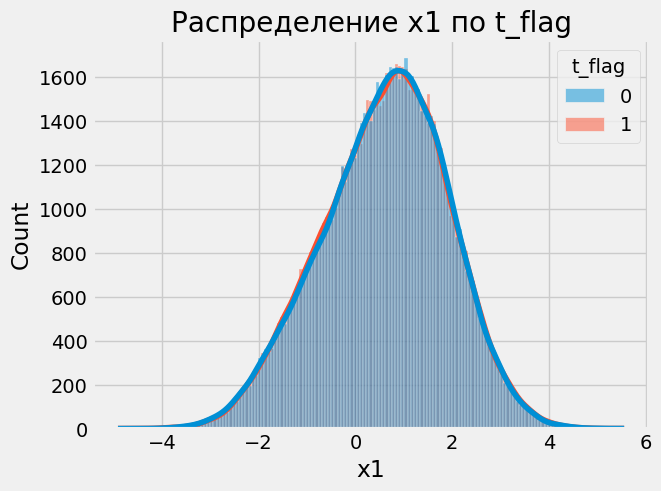

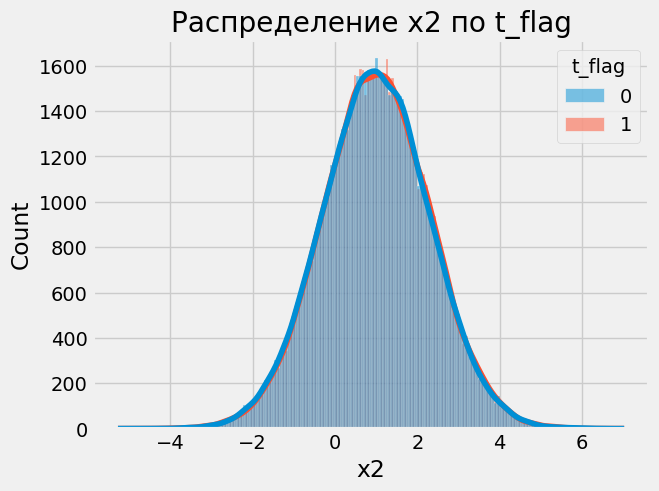

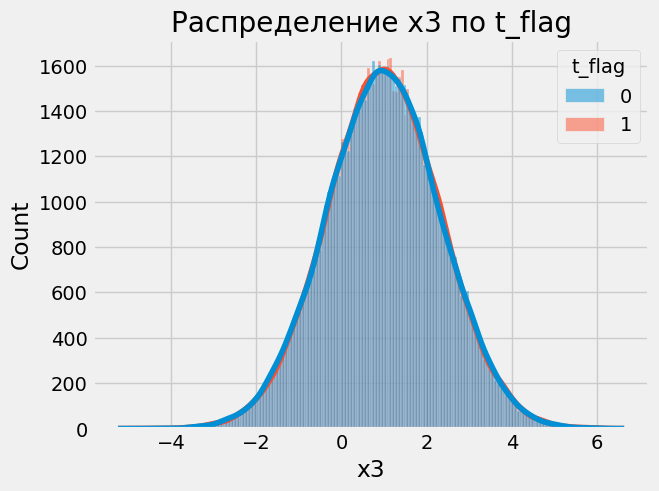

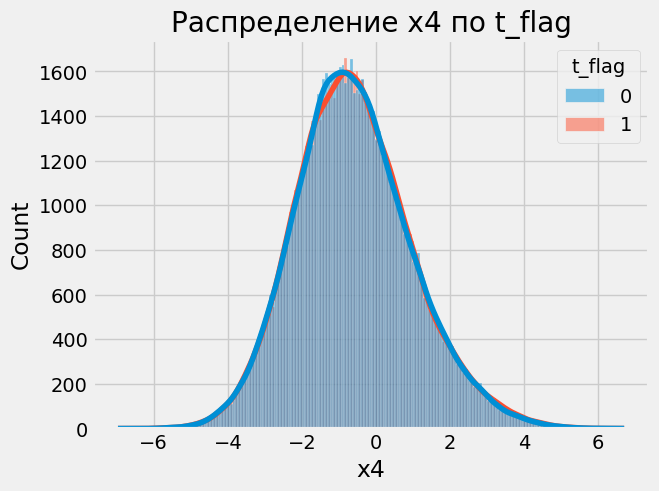

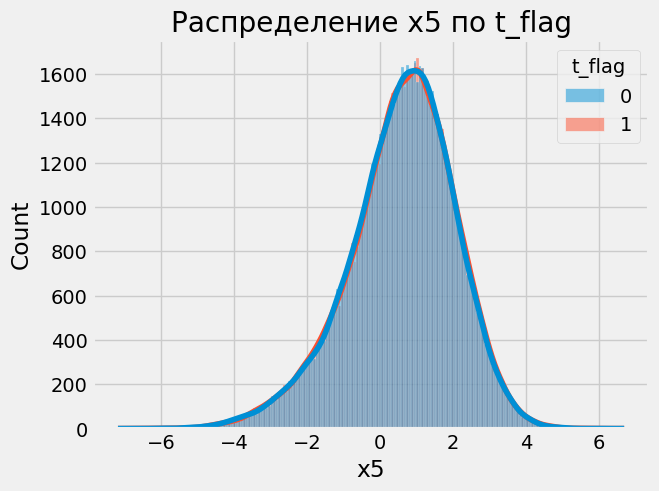

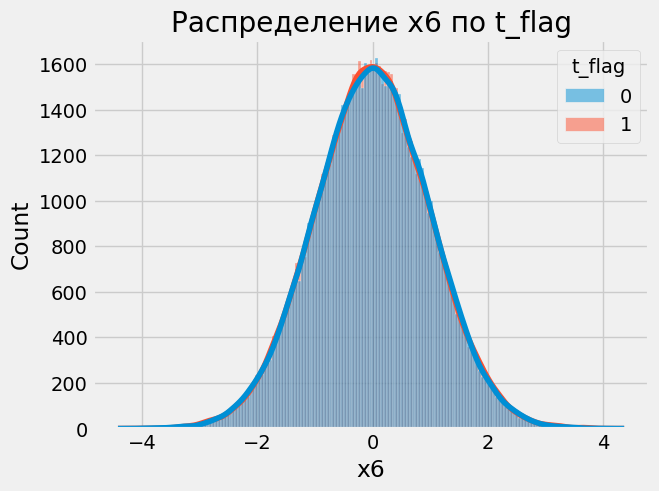

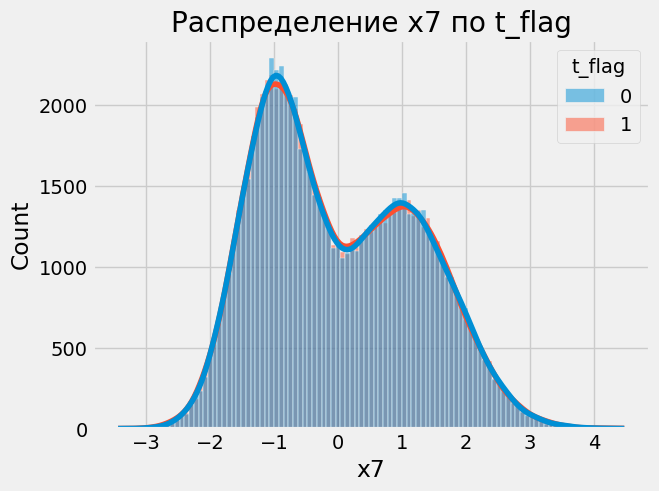

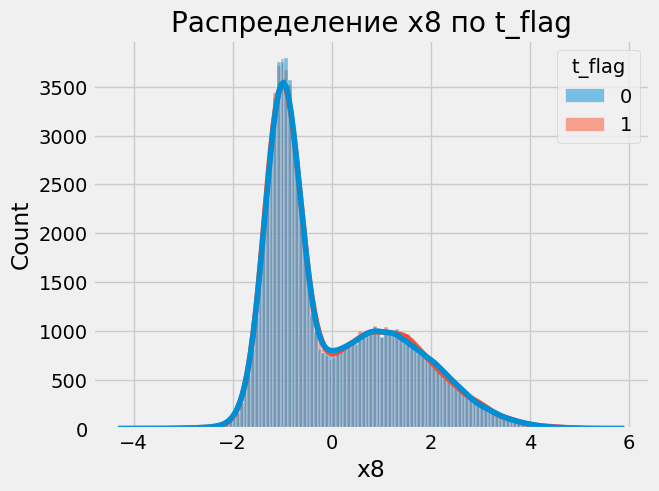

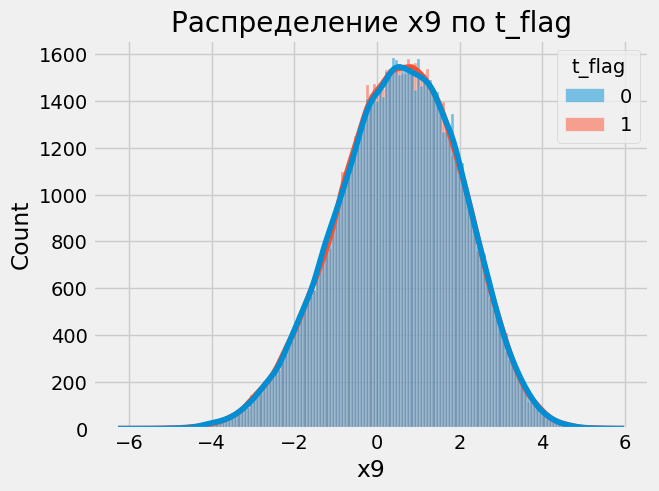

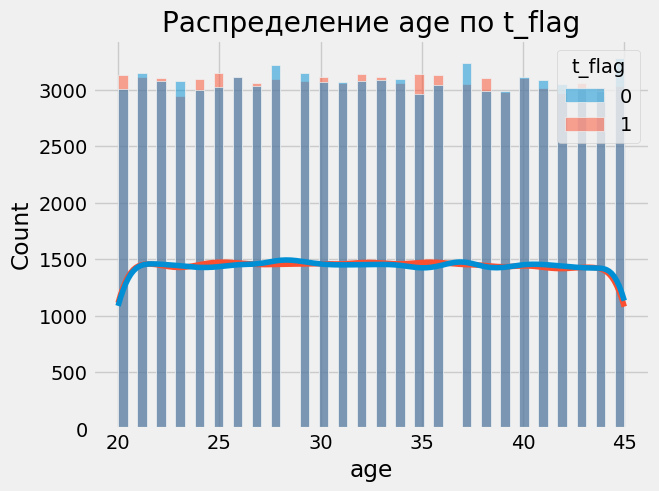

=== Анализ для канала: sms ===


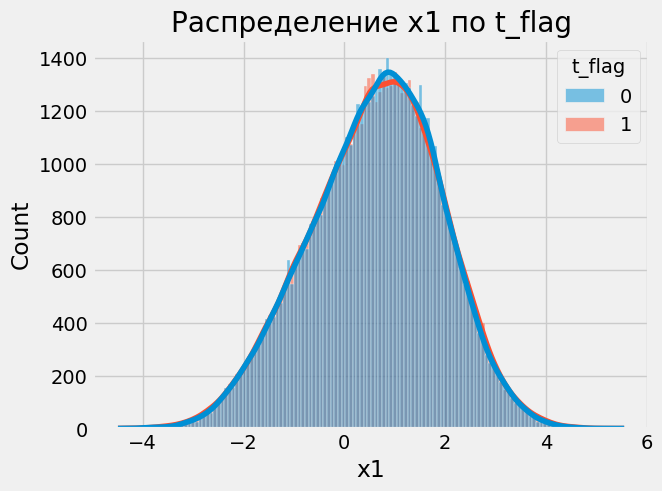

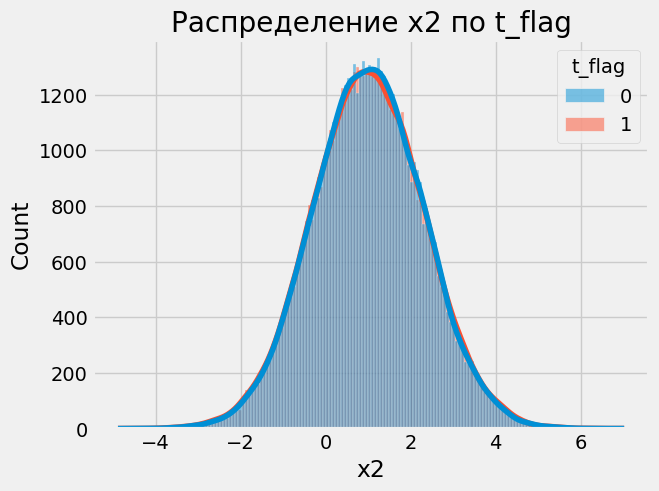

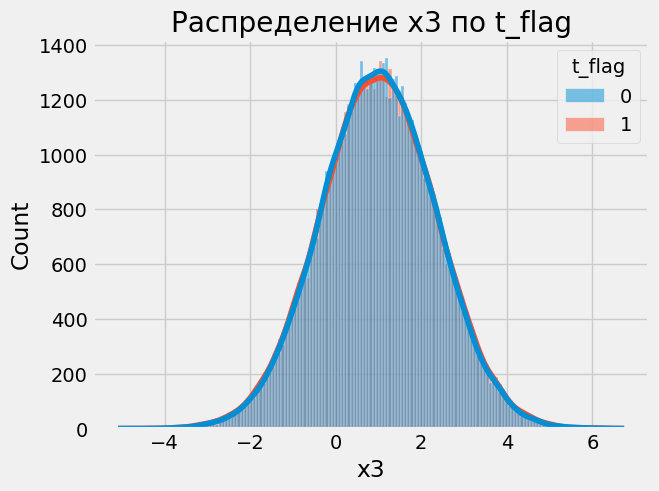

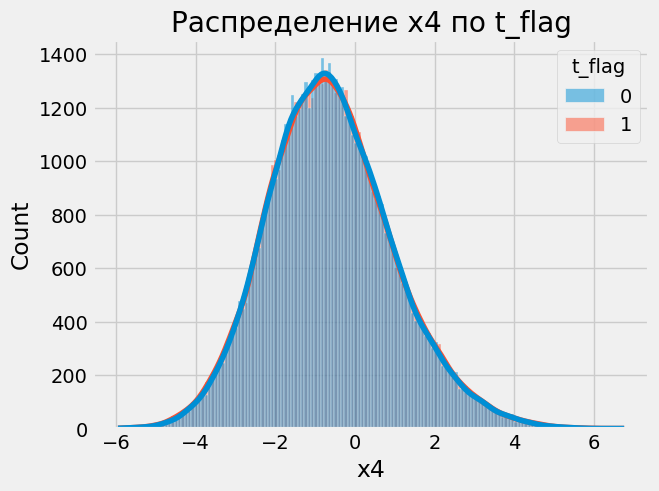

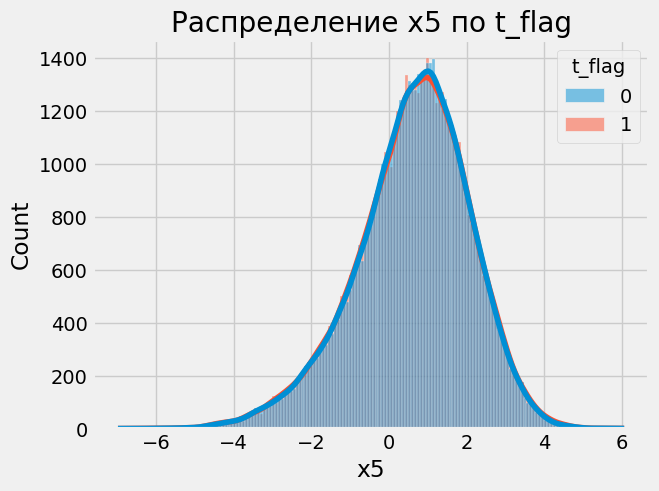

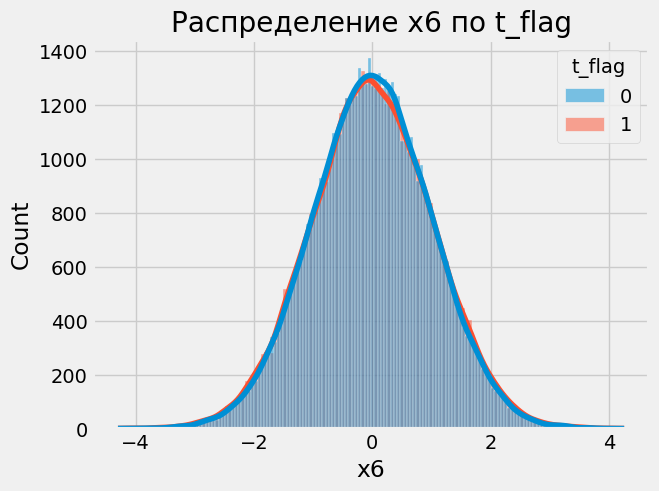

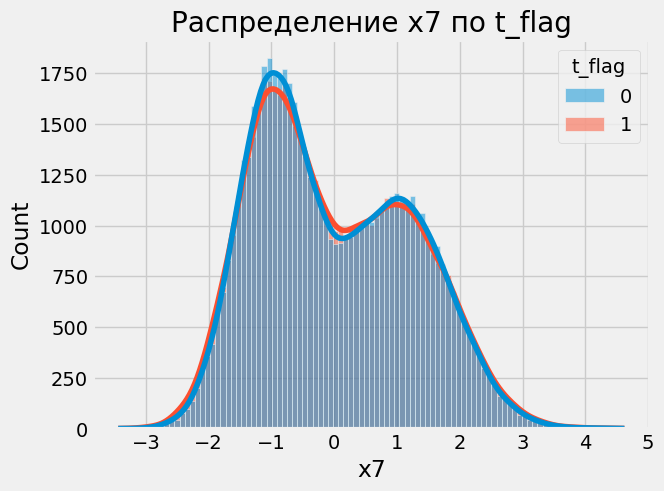

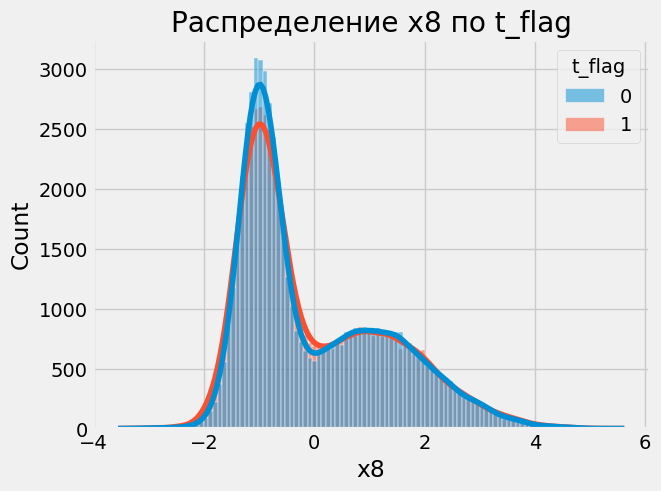

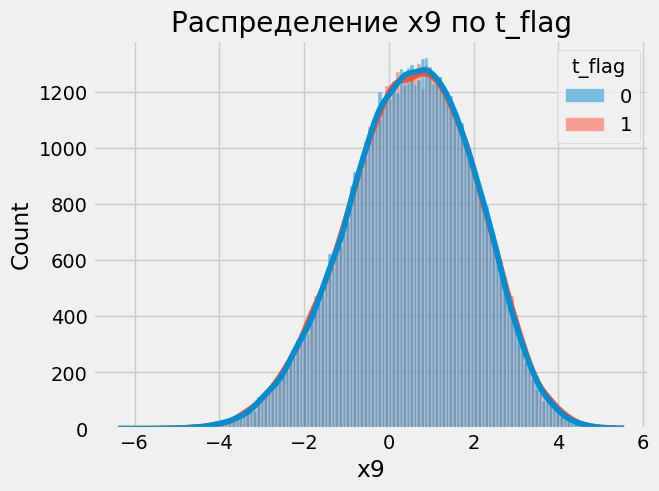

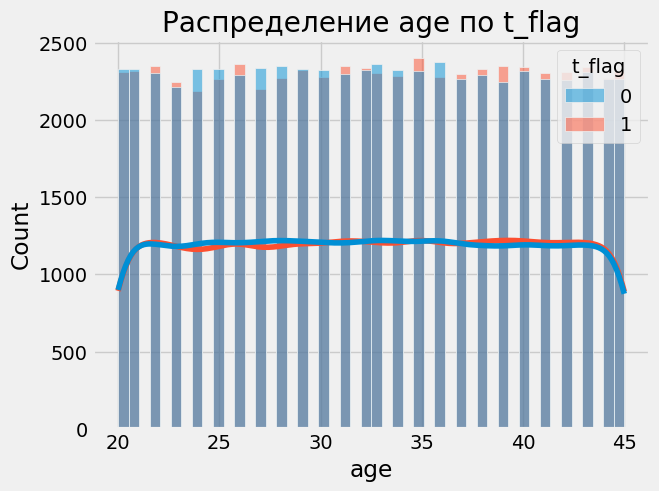

=== Анализ для канала: banner ===


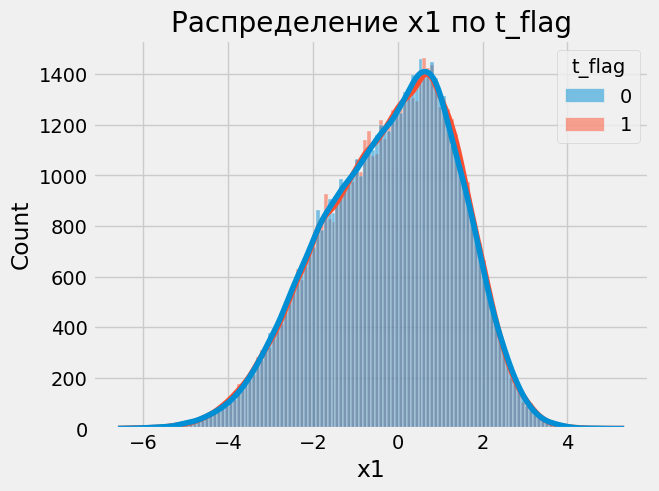

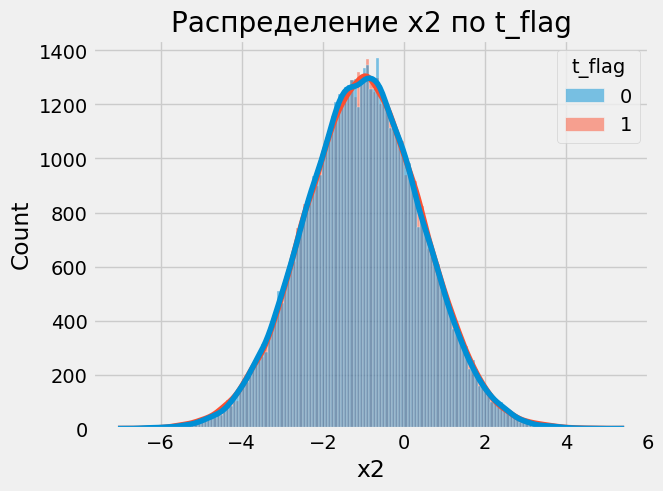

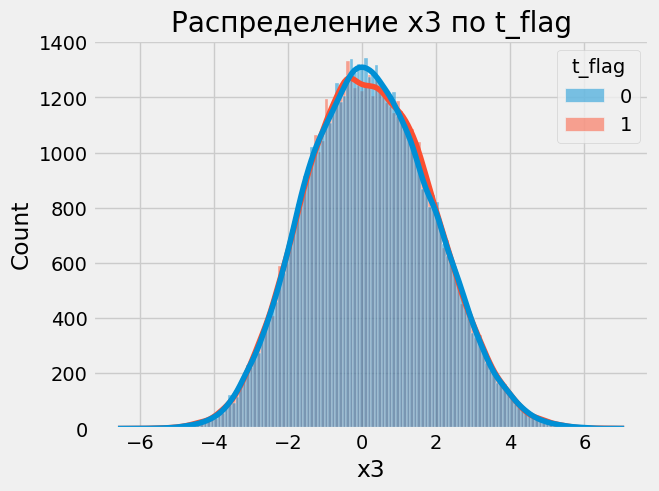

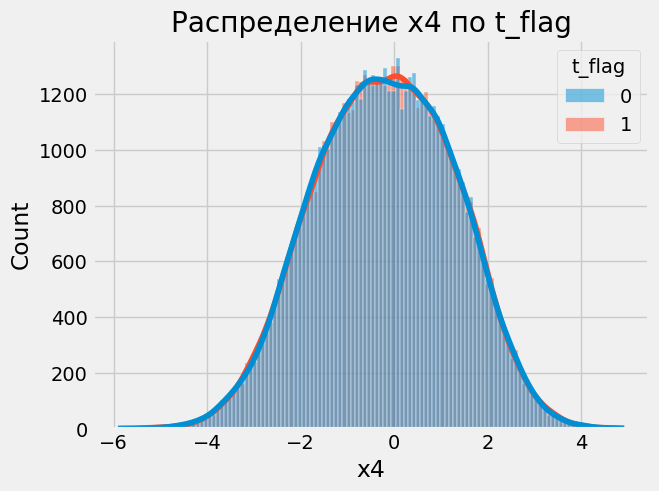

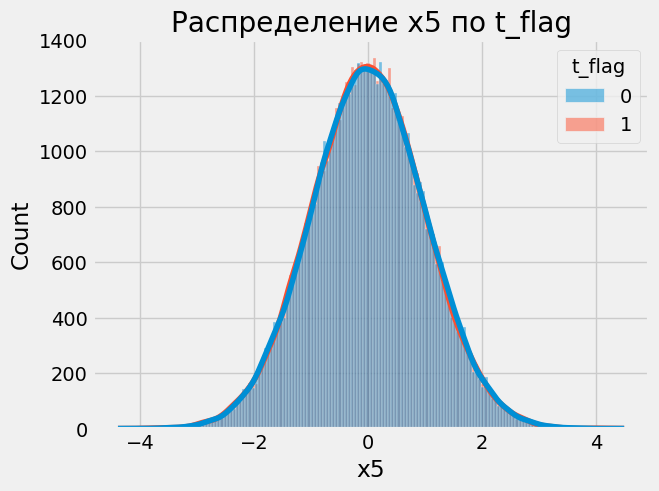

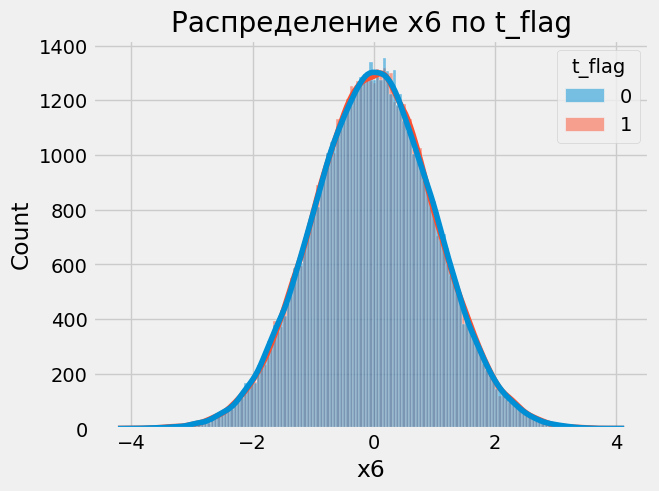

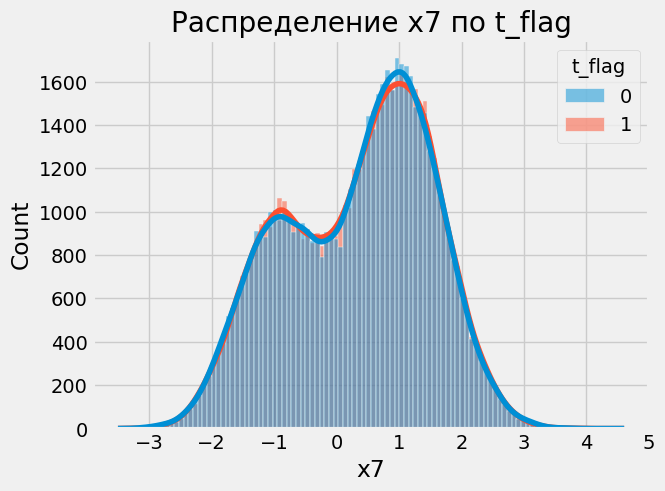

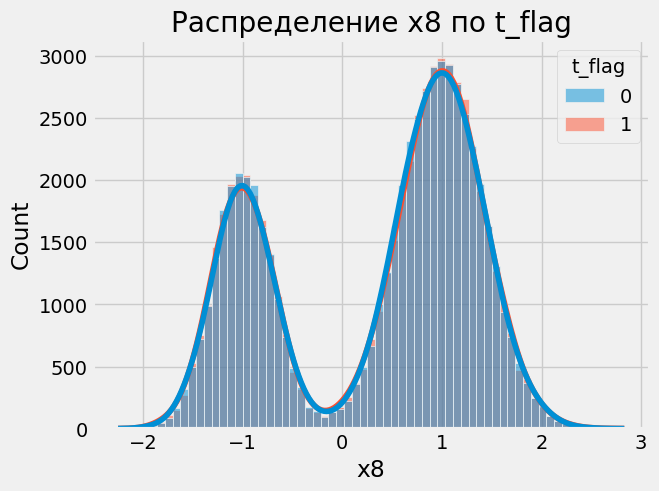

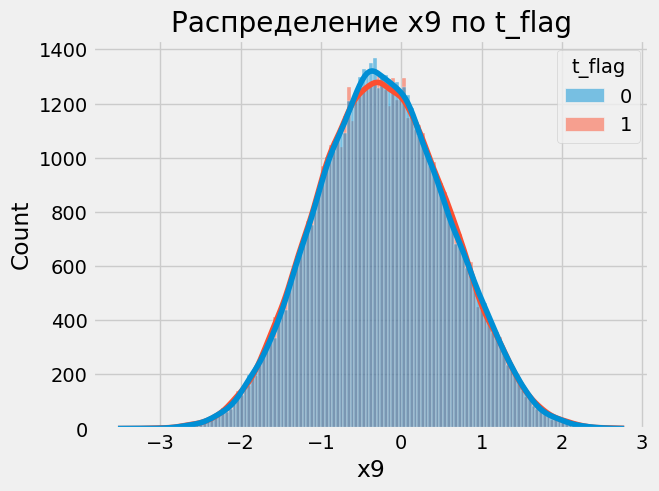

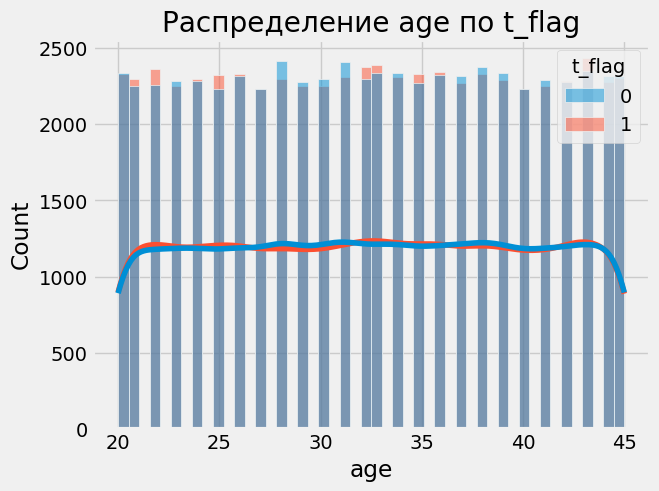

=== Анализ для канала: other_ads ===


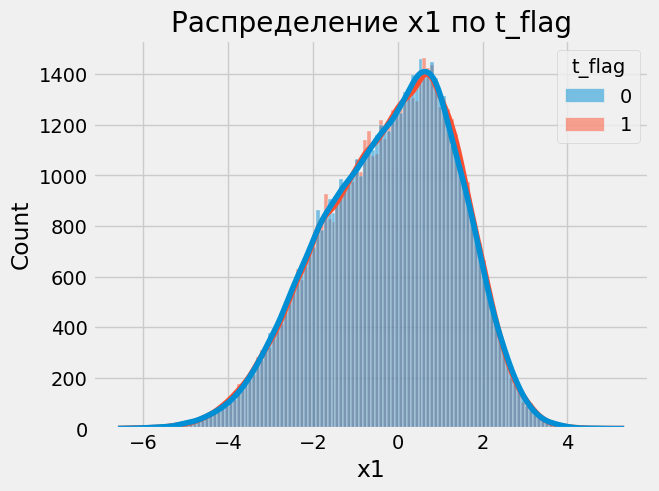

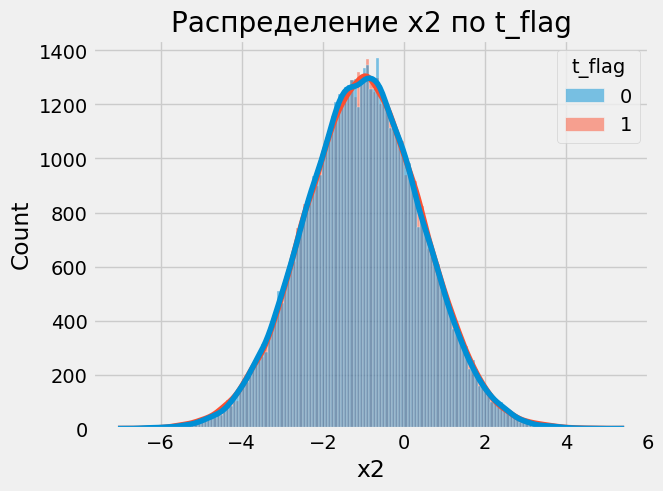

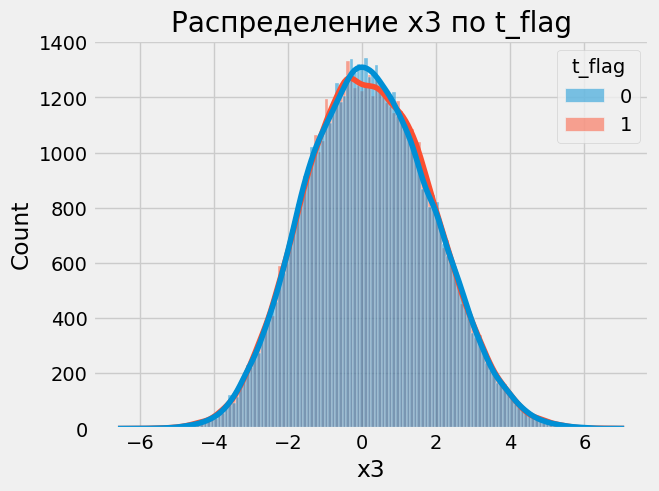

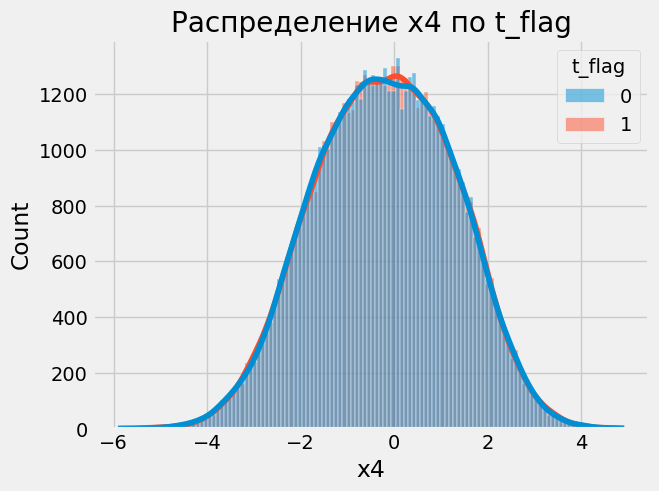

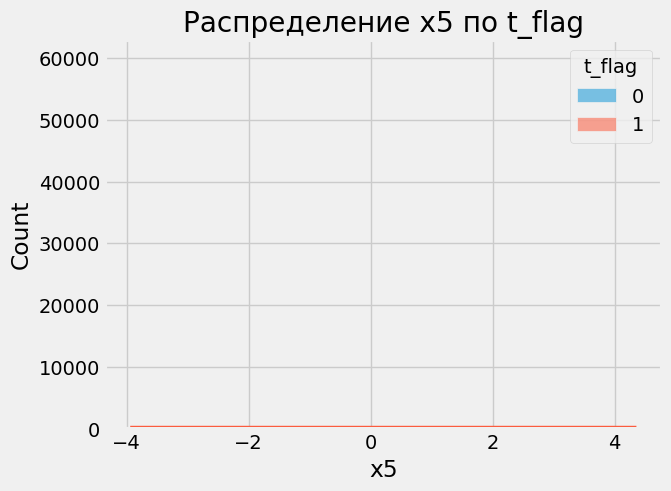

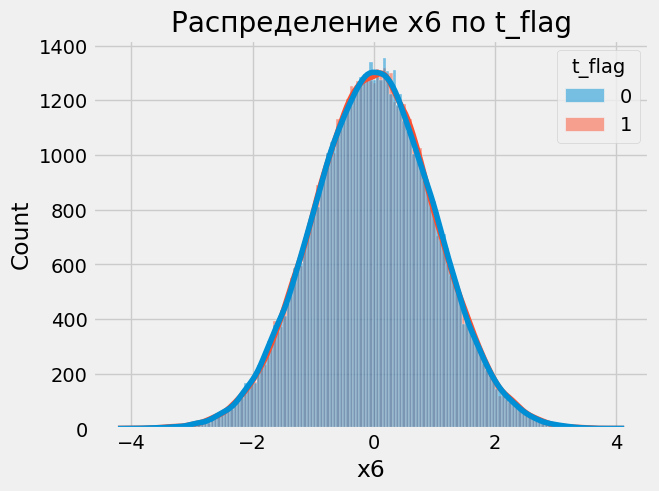

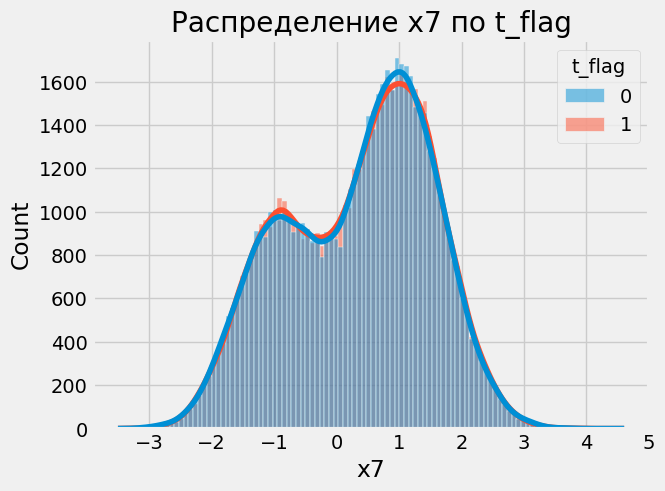

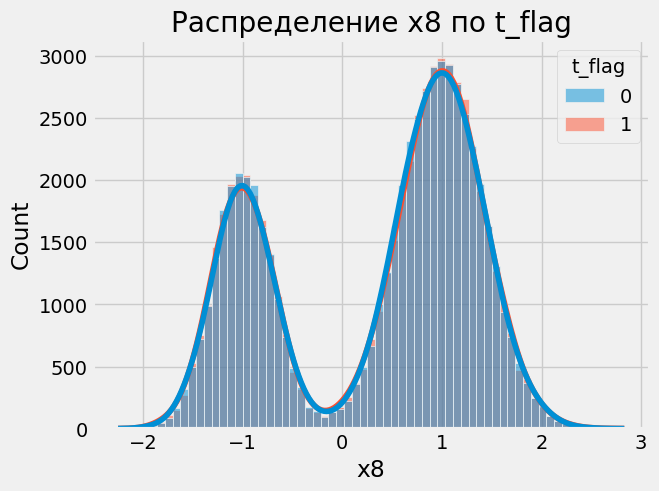

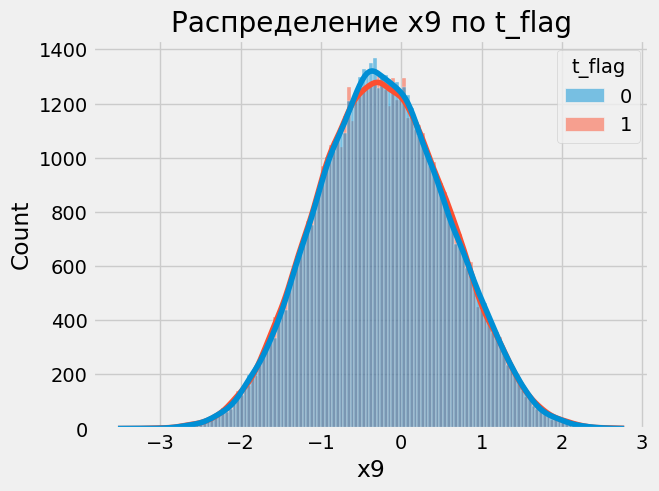

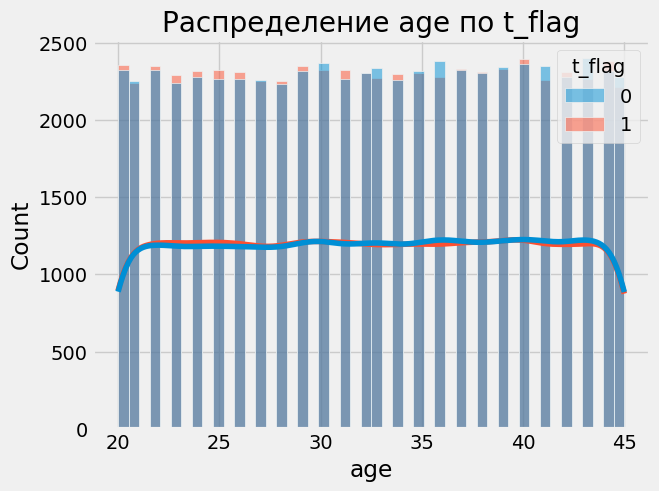

In [707]:
for channel in ['push', 'sms', 'banner', 'other_ads']:
    # Фильтрация данных по каналу
    print(f"=== Анализ для канала: {channel} ===")
    df_channel = final_result[final_result['channel'] == channel]
    for col in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']:
        sns.histplot(data=df_channel, x=col, hue='t_flag', kde=True).set_title(f'Распределение {col} по t_flag')
        plt.show()

In [708]:
columns_to_check = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']

In [709]:
for channel in ['push', 'sms', 'banner', 'other_ads']:
    # Фильтрация данных по каналу
    print(f"=== Анализ для канала: {channel} ===")
    df_channel = final_result[final_result['channel'] == channel]
    for col in columns_to_check:
      psi = calculate_psi(expected = df_channel[df_channel.t_flag == 0][col], actual = df_channel[df_channel.t_flag== 1][col])
      print(f'psi для признака {col} равно {psi}')

=== Анализ для канала: push ===
psi для признака x1 равно 0.00027677445013970283
psi для признака x2 равно 0.0002156196222605535
psi для признака x3 равно 0.00018391812056889502
psi для признака x4 равно 0.0002637229213707486
psi для признака x5 равно 0.00021383738927209807
psi для признака x6 равно 0.000213586268918342
psi для признака x7 равно 0.00016455056519692465
psi для признака x8 равно 0.0003232298576233026
psi для признака x9 равно 5.252590738341366e-05
psi для признака age равно 0.00023436883870353193
=== Анализ для канала: sms ===
psi для признака x1 равно 0.0004274463555730168
psi для признака x2 равно 0.0002414577760664222
psi для признака x3 равно 0.00044943491025303627
psi для признака x4 равно 0.00012903805487913053
psi для признака x5 равно 0.00023878230195627337
psi для признака x6 равно 0.0011320754068278535
psi для признака x7 равно 0.0019788135359556903
psi для признака x8 равно 0.009678612186922909
psi для признака x9 равно 0.000170972878210721
psi для признака ag

In [ ]:
# меньше 0.1

In [710]:
# Перебор всех каналов
for channel in ['push', 'sms', 'banner', 'other_ads']:
    # Фильтрация данных по каналу
    df_channel = final_result[final_result['channel'] == channel]

    print(f"=== Анализ для канала: {channel} ===")

    # Перебор всех столбцов для анализа
    for col in columns_to_check:
        df_channel[col+ '_bin'] = pd.qcut (df_channel[col], q=6, duplicates='drop')
        tmp = df_channel.groupby(by=[col+ '_bin', 't_flag']).agg({'target': 'mean'}).reset_index()
        tmp_1 = tmp[tmp[ 't_flag']==1].drop(columns='t_flag').set_index(col+ '_bin')
        tmp_0 = tmp[tmp['t_flag'] ==0].drop(columns='t_flag').set_index(col+ '_bin')
        print(f"Столбец: {col+ '_bin'}")
        best_uplift = tmp_1 - tmp_0
        print(best_uplift)

=== Анализ для канала: push ===
Столбец: x1_bin
                                 target
x1_bin                                 
(-4.9110000000000005, -0.709]  0.153592
(-0.709, 0.0926]               0.417484
(0.0926, 0.688]                0.544223
(0.688, 1.228]                 0.591391
(1.228, 1.859]                 0.591408
(1.859, 5.554]                 0.604483
Столбец: x2_bin
                               target
x2_bin                               
(-5.276000000000001, -0.26]  0.465594
(-0.26, 0.441]               0.499399
(0.441, 0.997]               0.484433
(0.997, 1.557]               0.495413
(1.557, 2.256]               0.493866
(2.256, 7.023]               0.470520
Столбец: x3_bin
                                 target
x3_bin                                 
(-5.2490000000000006, -0.299]  0.508251
(-0.299, 0.419]                0.483234
(0.419, 0.993]                 0.471899
(0.993, 1.57]                  0.471736
(1.57, 2.291]                  0.476922
(2.291, 6.639]  

In [711]:
# уберём дубликаты
scoring_user_data_09 = scoring_user_data[scoring_user_data["report_dt"] == "2024-09-30"]
scoring_user_data_09 = scoring_user_data_09.drop_duplicates(subset=[
    "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", 
    "report_dt", "user_id", "age", "city"
])
temp = scoring_user_data_09.groupby(['user_id', 'report_dt']).size().reset_index(name='cnt')
temp = temp[temp['cnt'] == 1]
valid_users_09 = temp['user_id'].unique()

scoring_user_data_01 = scoring_user_data[scoring_user_data["report_dt"] == "2025-01-31"]
scoring_user_data_01 = scoring_user_data_01.drop_duplicates(subset=[
    "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", 
    "report_dt", "user_id", "age", "city"
])
temp = scoring_user_data_01.groupby(['user_id', 'report_dt']).size().reset_index(name='cnt')
temp = temp[temp['cnt'] == 1]
valid_users_01 = temp['user_id'].unique()

In [713]:
final_result

,channel,user_id,t_flag,report_dt,prediction_dt,delivery_date,contract_date,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,push,1,1,2024-11-01,2024-09-30,2024-11-07,NaT,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,31,Ufa
1,sms,1,0,2024-11-01,2024-09-30,NaT,NaT,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,31,Ufa
2,push,2,0,2024-11-01,2024-09-30,NaT,NaT,0,1.011344,1.722951,-0.940343,-2.168505,0.595523,-1.301440,-1.173930,0.875189,1.805140,26,Moscow
3,push,3,0,2024-11-01,2024-09-30,NaT,NaT,0,0.821249,1.566195,2.545513,-0.737370,1.326130,0.815585,-0.530246,-1.624725,1.130743,20,Moscow
4,push,4,0,2024-11-01,2024-09-30,NaT,NaT,0,1.326766,2.319796,-0.188080,-1.759102,2.423625,-0.782383,1.604272,-0.767207,-0.122618,23,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519995,banner,4119995,1,2024-11-01,2024-09-30,2024-11-05,2024-11-13,1,-0.559786,-1.340919,0.487194,-0.776284,-0.584653,-0.939391,-1.649348,-1.456881,0.633357,37,Ufa
519996,banner,4119996,0,2024-11-01,2024-09-30,NaT,NaT,0,-1.156099,-0.993311,1.873156,1.149724,-0.321067,0.108914,1.028803,1.046502,-1.157034,25,Moscow
519997,banner,4119997,1,2024-11-01,2024-09-30,2024-11-04,NaT,0,-1.686740,-0.572579,1.613917,-1.190814,1.533141,-0.503989,1.241847,1.415810,-1.170135,23,Smolensk
519998,banner,4119998,0,2024-11-01,2024-09-30,NaT,2024-11-10,1,-0.058585,-2.629108,-2.948792,1.625710,-0.091360,0.780055,2.091102,1.224362,0.012898,35,Ufa


In [714]:
final_result_fixed = final_result[final_result['user_id'].isin(valid_users_09)]

In [716]:
final_result_fixed

,channel,user_id,t_flag,report_dt,prediction_dt,delivery_date,contract_date,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,push,1,1,2024-11-01,2024-09-30,2024-11-07,NaT,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,31,Ufa
1,sms,1,0,2024-11-01,2024-09-30,NaT,NaT,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,31,Ufa
2,push,2,0,2024-11-01,2024-09-30,NaT,NaT,0,1.011344,1.722951,-0.940343,-2.168505,0.595523,-1.301440,-1.173930,0.875189,1.805140,26,Moscow
3,push,3,0,2024-11-01,2024-09-30,NaT,NaT,0,0.821249,1.566195,2.545513,-0.737370,1.326130,0.815585,-0.530246,-1.624725,1.130743,20,Moscow
4,push,4,0,2024-11-01,2024-09-30,NaT,NaT,0,1.326766,2.319796,-0.188080,-1.759102,2.423625,-0.782383,1.604272,-0.767207,-0.122618,23,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519995,banner,4119995,1,2024-11-01,2024-09-30,2024-11-05,2024-11-13,1,-0.559786,-1.340919,0.487194,-0.776284,-0.584653,-0.939391,-1.649348,-1.456881,0.633357,37,Ufa
519996,banner,4119996,0,2024-11-01,2024-09-30,NaT,NaT,0,-1.156099,-0.993311,1.873156,1.149724,-0.321067,0.108914,1.028803,1.046502,-1.157034,25,Moscow
519997,banner,4119997,1,2024-11-01,2024-09-30,2024-11-04,NaT,0,-1.686740,-0.572579,1.613917,-1.190814,1.533141,-0.503989,1.241847,1.415810,-1.170135,23,Smolensk
519998,banner,4119998,0,2024-11-01,2024-09-30,NaT,2024-11-10,1,-0.058585,-2.629108,-2.948792,1.625710,-0.091360,0.780055,2.091102,1.224362,0.012898,35,Ufa


In [717]:
# проверка
channels = final_result_fixed['channel'].unique()

for channel in channels:
    channel_data = final_result_fixed[final_result_fixed['channel'] == channel]

    # Разбиваем на группы по t_flag
    treatment_data = channel_data[channel_data['t_flag'] == 1]
    control_data = channel_data[channel_data['t_flag'] == 0]

    treatment_count = treatment_data.shape[0]
    control_count = control_data.shape[0]

    print(f"\n=== Анализ для канала: '{channel}' ===")
    print(f"Количество тестовой группы (t_flag=1): {treatment_count}")
    print(f"Количество контрольной группы (t_flag=0): {control_count}")

    # Проверка: если одна из групп пуста, данные некорректны для моделирования
    if treatment_count == 0 or control_count == 0:
        print(f"Данные для канала '{channel}' некорректны: одна из групп пуста. Моделирование не проводится.")
        continue

    # Проверяем, что в колонке 'target' содержатся только значения 0 и 1 (NaN допустимы)
    unique_targets = channel_data['target'].dropna().unique()
    if not set(unique_targets).issubset({0, 1}):
        print(f"Данные для канала '{channel}' некорректны: обнаружены недопустимые значения в 'target' -> {unique_targets}.")
        print("Моделирование не проводится.")
        continue

    # Рассчитываем среднее значение таргета для тестовой и контрольной групп (игнорируя NaN)
    treatment_mean = treatment_data['target'].dropna().mean()
    control_mean = control_data['target'].dropna().mean()
    uplift = treatment_mean - control_mean

    print(f"Среднее значение таргета в тестовой группе (t_flag=1): {treatment_mean:.4f}")
    print(f"Среднее значение таргета в контрольной группе (t_flag=0): {control_mean:.4f}")
    print(f"Uplift (тестовая минус контрольная): {uplift:.4f}")



=== Анализ для канала: 'push' ===
Количество тестовой группы (t_flag=1): 80000
Количество контрольной группы (t_flag=0): 80000
Среднее значение таргета в тестовой группе (t_flag=1): 0.6870
Среднее значение таргета в контрольной группе (t_flag=0): 0.2021
Uplift (тестовая минус контрольная): 0.4849

=== Анализ для канала: 'sms' ===
Количество тестовой группы (t_flag=1): 60000
Количество контрольной группы (t_flag=0): 60000
Среднее значение таргета в тестовой группе (t_flag=1): 0.3986
Среднее значение таргета в контрольной группе (t_flag=0): 0.6849
Uplift (тестовая минус контрольная): -0.2863

=== Анализ для канала: 'other_ads' ===
Количество тестовой группы (t_flag=1): 60000
Количество контрольной группы (t_flag=0): 60000
Среднее значение таргета в тестовой группе (t_flag=1): 0.7023
Среднее значение таргета в контрольной группе (t_flag=0): 0.4007
Uplift (тестовая минус контрольная): 0.3015

=== Анализ для канала: 'banner' ===
Количество тестовой группы (t_flag=1): 60000
Количество контр

In [686]:
final_result_path = "final_result.csv"
final_result_fixed.to_csv(final_result_path, index=False, encoding="utf-8")

In [718]:
final_result_fixed.groupby(['channel', 't_flag']).mean(numeric_only=True)

user_id    target        x1        x2        x3  \
channel   t_flag                                                         
banner    0       4.059840e+06  0.400733 -0.200788 -1.005438  0.195224   
          1       4.060159e+06  0.687750 -0.190153 -0.996064  0.201646   
other_ads 0       2.060079e+06  0.400733 -0.200788 -1.005438  0.195224   
          1       2.059920e+06  0.702267 -0.190153 -0.996064  0.201646   
push      0       8.003378e+04  0.202150  0.604476  0.991262  0.989826   
          1       7.996722e+04  0.687025  0.601202  1.004994  0.996935   
sms       0       7.994141e+04  0.684917  0.612525  1.002071  0.996160   
          1       1.079941e+06  0.398617  0.613410  1.001479  0.996336   

                        x4        x5        x6        x7        x8        x9  \
channel   t_flag                                                               
banner    0      -0.201540  0.005851 -0.000878  0.335597  0.333879 -0.231895   
          1      -0.199495 -0.003222  0.002184  0.335707  0.332511 -0.234196   
other_ads 0      -0.201540  0.000000 -0.000878  0.335597  0.333879 -0.231895   
          1      -0.199495 -0.003222  0.002184  0.335707  0.332511 -0.234196   
push      0      -0.606210  0.592924 -0.002248 -0.002248 -0.000358  0.524898   
          1      -0.596487  0.601505 -0.002147 -0.004232 -0.003318  0.523636   
sms       0      -0.605374  0.609060 -0.002922 -0.002243 -0.003985  0.531859   
          1      -0.606077  0.607142 -0.003577 -0.003194 -0.002058  0.532910   

                        age  
channel   t_flag             
banner    0       32.531317  
          1       32.500350  
other_ads 0       32.565050  
          1       32.494200  
push      0       32.504013  
          1       32.448462  
sms       0       32.459500  
          1       32.538800

In [719]:
final_result_fixed.groupby(['channel', 't_flag']).median(numeric_only=True)

user_id  target        x1        x2        x3        x4  \
channel   t_flag                                                              
banner    0       4059814.0     0.0 -0.039344 -1.000710  0.151140 -0.191527   
          1       4060191.5     1.0 -0.029260 -0.992088  0.163890 -0.182136   
other_ads 0       2059939.5     0.0 -0.039344 -1.000710  0.151140 -0.191527   
          1       2060077.0     1.0 -0.029260 -0.992088  0.163890 -0.182136   
push      0         80012.5     0.0  0.690167  0.991941  0.991280 -0.698398   
          1         79985.5     1.0  0.684945  1.003702  0.994629 -0.683922   
sms       0         79869.5     1.0  0.695846  1.001579  0.995263 -0.692065   
          1       1079869.5     0.0  0.688788  0.996818  0.998904 -0.689447   

                        x5        x6        x7        x8        x9   age  
channel   t_flag                                                          
banner    0       0.004826  0.001446  0.520809  0.712336 -0.245529  33.0  
          1      -0.004370  0.006098  0.513940  0.719739 -0.246031  33.0  
other_ads 0       0.000000  0.001446  0.520809  0.712336 -0.245529  33.0  
          1      -0.004370  0.006098  0.513940  0.719739 -0.246031  32.0  
push      0       0.715804  0.000645 -0.208016 -0.561839  0.575092  32.0  
          1       0.723315 -0.003707 -0.208410 -0.561366  0.573658  32.0  
sms       0       0.731157 -0.004754 -0.206023 -0.561788  0.580557  32.0  
          1       0.724927 -0.008930 -0.188274 -0.510997  0.583088  33.0

In [720]:
# Перебор всех каналов
for channel in ['push', 'sms', 'banner', 'other_ads']:
    # Фильтрация данных по каналу
    df_channel = final_result[final_result['channel'] == channel]

    print(f"=== Анализ для канала: {channel} ===")

    # Перебор всех столбцов для анализа
    for col in columns_to_check:
        df_channel[col+ '_bin'] = pd.qcut (df_channel[col], q=6, duplicates='drop')
        tmp = df_channel.groupby(by=[col+ '_bin', 't_flag']).agg({'target': 'mean'}).reset_index()
        tmp_1 = tmp[tmp[ 't_flag']==1].drop(columns='t_flag').set_index(col+ '_bin')
        tmp_0 = tmp[tmp['t_flag'] ==0].drop(columns='t_flag').set_index(col+ '_bin')
        print(f"Столбец: {col+ '_bin'}")
        best_uplift = tmp_1 - tmp_0
        print(best_uplift)

=== Анализ для канала: push ===
Столбец: x1_bin
                                 target
x1_bin                                 
(-4.9110000000000005, -0.709]  0.153592
(-0.709, 0.0926]               0.417484
(0.0926, 0.688]                0.544223
(0.688, 1.228]                 0.591391
(1.228, 1.859]                 0.591408
(1.859, 5.554]                 0.604483
Столбец: x2_bin
                               target
x2_bin                               
(-5.276000000000001, -0.26]  0.465594
(-0.26, 0.441]               0.499399
(0.441, 0.997]               0.484433
(0.997, 1.557]               0.495413
(1.557, 2.256]               0.493866
(2.256, 7.023]               0.470520
Столбец: x3_bin
                                 target
x3_bin                                 
(-5.2490000000000006, -0.299]  0.508251
(-0.299, 0.419]                0.483234
(0.419, 0.993]                 0.471899
(0.993, 1.57]                  0.471736
(1.57, 2.291]                  0.476922
(2.291, 6.639]  

In [ ]:
!pip install scikit-uplift -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
#!pip install --upgrade scikit-learn scikit-uplift -q

In [ ]:
!pip install scikit-learn -q

In [ ]:
#!pip install scikit-learn==1.1.3 scikit-uplift -q

In [723]:
final_result_fixed

,channel,user_id,t_flag,report_dt,prediction_dt,delivery_date,contract_date,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,push,1,1,2024-11-01,2024-09-30,2024-11-07,NaT,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,31,Ufa
1,sms,1,0,2024-11-01,2024-09-30,NaT,NaT,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,31,Ufa
2,push,2,0,2024-11-01,2024-09-30,NaT,NaT,0,1.011344,1.722951,-0.940343,-2.168505,0.595523,-1.301440,-1.173930,0.875189,1.805140,26,Moscow
3,push,3,0,2024-11-01,2024-09-30,NaT,NaT,0,0.821249,1.566195,2.545513,-0.737370,1.326130,0.815585,-0.530246,-1.624725,1.130743,20,Moscow
4,push,4,0,2024-11-01,2024-09-30,NaT,NaT,0,1.326766,2.319796,-0.188080,-1.759102,2.423625,-0.782383,1.604272,-0.767207,-0.122618,23,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519995,banner,4119995,1,2024-11-01,2024-09-30,2024-11-05,2024-11-13,1,-0.559786,-1.340919,0.487194,-0.776284,-0.584653,-0.939391,-1.649348,-1.456881,0.633357,37,Ufa
519996,banner,4119996,0,2024-11-01,2024-09-30,NaT,NaT,0,-1.156099,-0.993311,1.873156,1.149724,-0.321067,0.108914,1.028803,1.046502,-1.157034,25,Moscow
519997,banner,4119997,1,2024-11-01,2024-09-30,2024-11-04,NaT,0,-1.686740,-0.572579,1.613917,-1.190814,1.533141,-0.503989,1.241847,1.415810,-1.170135,23,Smolensk
519998,banner,4119998,0,2024-11-01,2024-09-30,NaT,2024-11-10,1,-0.058585,-2.629108,-2.948792,1.625710,-0.091360,0.780055,2.091102,1.224362,0.012898,35,Ufa


## Uplift для разных каналов:

# 1. Канал: 'push'
Uplift (тестовая минус контрольная): +0.4849

Тестовая группа показала значительное увеличение целевой метрики по сравнению с контрольной группой.

Это самый эффективный канал среди всех анализируемых.

Рекомендация: Увеличить инвестиции в канал 'push', так как он демонстрирует высокую эффективность.

# 2. Канал: 'other_ads'
Uplift (тестовая минус контрольная): +0.3015

Тестовая группа также показала положительный результат, но uplift меньше, чем у канала 'push'.

Канал эффективен, но требует дополнительного анализа для оптимизации.

Рекомендация: Продолжать использовать канал, но изучить, какие именно факторы (например, креативы, аудитория) влияют на его эффективность.

# 3. Канал: 'banner'
Uplift (тестовая минус контрольная): +0.2870

Результаты схожи с каналом 'other_ads', но uplift немного ниже.

Канал демонстрирует стабильную эффективность.

# 4. Канал: 'sms'
Uplift (тестовая минус контрольная): -0.2863

Тестовая группа показала отрицательный uplift, то есть целевая метрика в тестовой группе ниже, чем в контрольной.

Это указывает на то, что канал 'sms' неэффективен или даже вреден для целевой метрики.

## Решение :

Не использовать канал 'sms'.

3 Итоговые рекомендации:
Приоритетный канал: 'push' (наибольший uplift).

Эффективные каналы: 'other_ads' и 'banner' (положительный uplift, но меньше, чем у 'push').

Проблемный канал: 'sms' (отрицательный uplift, требует пересмотра стратегии).

Рекомендация: Оптимизировать баннеры (например, улучшить дизайн или таргетинг) для повышения uplift.
KS-тест для канала 'push':

Для всех признаков, использованных для оценки propensity score на канале 'push' (x1, x2, x3, ..., x9 и age), p-value оказалось высокое (более 0.05), что указывает на отсутствие статистически значимых различий между распределениями для тестовой и контрольной группы. Это предполагает, что признаки не сильно влияют на решение о назначении пользователя в одну из групп и их влияние на модель может быть ограниченным.

В частности:

Для всех признаков (например, x1, x2, x3 и другие), p-value остаются выше 0.05, что подтверждает гипотезу о том, что различий между группами нет.

Заключение:

Канал 'sms' не подходит для дальнейшего анализа из-за отсутствия данных в контрольной группе.

## Результаты по признакам для канала push:

Для всех признаков (x1, x2, x3, x4, x5, x6, x7, x8, x9, age) p-value значительно больше 0.05.

Это указывает на то, что после применения Propensity Score Matching контрольная и тестовая группы сбалансированы по этим признакам.

Таким образом, на основе p-value всех признаков для канала push, можно сделать вывод, что группы стали сбалансированы по важным признакам, и различий между контрольной и тестовой группами по этим признакам нет.

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

## Подход LogisticRegression baseline

In [734]:
final_result_fixed

,channel,user_id,t_flag,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age_scaled,city_encoded2
0,push,1,1,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,-0.200577,1.251067
1,sms,1,0,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,-0.200577,1.251067
2,push,2,0,0,1.011344,1.722951,-0.940343,-2.168505,0.595523,-1.301440,-1.173930,0.875189,1.805140,-0.867841,-1.256526
3,push,3,0,0,0.821249,1.566195,2.545513,-0.737370,1.326130,0.815585,-0.530246,-1.624725,1.130743,-1.668558,-1.256526
4,push,4,0,0,1.326766,2.319796,-0.188080,-1.759102,2.423625,-0.782383,1.604272,-0.767207,-0.122618,-1.268200,1.251067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519995,banner,4119995,1,1,-0.559786,-1.340919,0.487194,-0.776284,-0.584653,-0.939391,-1.649348,-1.456881,0.633357,0.600140,1.251067
519996,banner,4119996,0,0,-1.156099,-0.993311,1.873156,1.149724,-0.321067,0.108914,1.028803,1.046502,-1.157034,-1.001294,-1.256526
519997,banner,4119997,1,0,-1.686740,-0.572579,1.613917,-1.190814,1.533141,-0.503989,1.241847,1.415810,-1.170135,-1.268200,-0.002729
519998,banner,4119998,0,1,-0.058585,-2.629108,-2.948792,1.625710,-0.091360,0.780055,2.091102,1.224362,0.012898,0.333234,1.251067


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Кодируем city через Label Encoding
label_encoder = LabelEncoder()
final_result_fixed['city_encoded'] = label_encoder.fit_transform(final_result_fixed['city'])

# 2. Масштабируем age
scaler = StandardScaler()
final_result_fixed['age_scaled'] = scaler.fit_transform(final_result_fixed[['age']])
final_result_fixed['city_encoded2'] = scaler.fit_transform(final_result_fixed[['city_encoded']])
final_result_fixed = final_result_fixed.drop(columns = ['city','delivery_date','contract_date','age','city_encoded'])

In [728]:
final_result['city'].unique()

array(['Ufa', 'Moscow', 'Smolensk'], dtype=object)

In [732]:
final_result_fixed = final_result_fixed.drop(columns = ['prediction_dt','report_dt'])

In [736]:
final_result_fixed['user_id'] = final_result_fixed['user_id'].astype(int)
final_result_fixed['t_flag'] = final_result_fixed['t_flag'].astype(int)
final_result_fixed['target'] = final_result_fixed['target'].astype(int)

banner_df = final_result_fixed[final_result_fixed['channel'] == 'banner'].reset_index()
other_ads_df = final_result_fixed[final_result_fixed['channel'] == 'other_ads'].reset_index()
push_df = final_result_fixed[final_result_fixed['channel'] == 'push'].reset_index()

In [737]:
push_df

,index,channel,user_id,t_flag,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age_scaled,city_encoded2
0,0,push,1,1,0,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,-0.200577,1.251067
1,2,push,2,0,0,1.011344,1.722951,-0.940343,-2.168505,0.595523,-1.301440,-1.173930,0.875189,1.805140,-0.867841,-1.256526
2,3,push,3,0,0,0.821249,1.566195,2.545513,-0.737370,1.326130,0.815585,-0.530246,-1.624725,1.130743,-1.668558,-1.256526
3,4,push,4,0,0,1.326766,2.319796,-0.188080,-1.759102,2.423625,-0.782383,1.604272,-0.767207,-0.122618,-1.268200,1.251067
4,5,push,5,1,0,-0.531544,2.317090,1.833935,-1.256844,1.219159,0.128766,0.822677,-1.024798,-1.111676,-1.535105,-1.256526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,219992,push,159996,1,1,1.776626,0.238944,-0.435217,0.960252,-0.778458,0.703683,-0.407662,1.491444,1.860428,1.267404,1.251067
159996,219993,push,159997,1,0,0.925286,0.620039,1.685855,-2.097477,1.010336,-0.109139,0.635583,-1.300016,0.297277,1.400857,1.251067
159997,219995,push,159998,1,0,0.281577,2.464270,1.593328,-0.261780,1.453598,0.146690,1.848105,-0.615015,-1.220281,-1.535105,1.251067
159998,219996,push,159999,1,0,1.030939,0.093441,2.134514,-2.266315,1.130643,-1.435042,0.019245,-1.318046,0.876936,1.133951,1.251067


In [ ]:
'''
# Вычисляем веса
push_df_recovered['weight'] = push_df_recovered.apply(
    lambda row: 1 / row['propensity_score'] if row['t_flag'] == 1 else 1 / (1 - row['propensity_score']),
    axis=1
)

# Применяем веса к данным (кроме столбцов 'index', 'channel', 'user_id', 't_flag', 'target')
weighted_columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age_scaled', 'city_encoded2']
push_df_recovered[weighted_columns] = push_df_recovered[weighted_columns].mul(push_df_recovered['weight'], axis=0)

# Удаляем propensity_score и weight
push_df_normalized = push_df_recovered.drop(columns=['propensity_score', 'weight'])
'''

In [738]:
push_df_recovered = push_df

In [739]:
banner_df

,index,channel,user_id,t_flag,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age_scaled,city_encoded2
0,400000,banner,4000000,0,0,-2.922272,0.909833,2.425844,-1.136510,0.840187,-1.584722,0.100812,0.896552,-0.898182,-1.001294,1.251067
1,400001,banner,4000001,0,1,0.542320,-0.614836,-1.695029,2.078754,-0.346983,1.248200,1.631589,0.840348,-0.201958,1.667762,-1.256526
2,400002,banner,4000002,1,0,-0.346799,-1.520802,0.875729,-0.941294,-0.014361,-0.447024,0.163856,1.000291,-0.386368,1.534309,1.251067
3,400003,banner,4000003,0,0,-1.302995,-0.985403,1.425449,-0.127989,-0.421505,-1.419178,-1.339884,-1.432641,0.154137,-0.334030,-0.002729
4,400004,banner,4000004,0,0,-4.909485,1.562389,3.252305,0.218705,0.286683,-0.044990,1.811109,0.548282,-2.021025,1.400857,-0.002729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,519995,banner,4119995,1,1,-0.559786,-1.340919,0.487194,-0.776284,-0.584653,-0.939391,-1.649348,-1.456881,0.633357,0.600140,1.251067
119996,519996,banner,4119996,0,0,-1.156099,-0.993311,1.873156,1.149724,-0.321067,0.108914,1.028803,1.046502,-1.157034,-1.001294,-1.256526
119997,519997,banner,4119997,1,0,-1.686740,-0.572579,1.613917,-1.190814,1.533141,-0.503989,1.241847,1.415810,-1.170135,-1.268200,-0.002729
119998,519998,banner,4119998,0,1,-0.058585,-2.629108,-2.948792,1.625710,-0.091360,0.780055,2.091102,1.224362,0.012898,0.333234,1.251067


In [740]:
train_banner, test_banner = train_test_split(banner_df.index, test_size=0.25, random_state=42)
train_other_ads, test_other_ads = train_test_split(other_ads_df.index, test_size=0.25, random_state=42)
train_push, test_push = train_test_split(push_df_recovered.index, test_size=0.25, random_state=42)

In [741]:
X_train_banner = banner_df.loc[train_banner].drop(columns = ['target','index'])
y_train_banner = banner_df.loc[train_banner].target
X_test_banner = banner_df.loc[test_banner].drop(columns = ['target','index'])
y_test_banner = banner_df.loc[test_banner].target

X_train_other_ads = other_ads_df.loc[train_other_ads].drop(columns = ['target','index'])
y_train_other_ads = other_ads_df.loc[train_other_ads].target
X_test_other_ads = other_ads_df.loc[test_other_ads].drop(columns = ['target','index'])
y_test_other_ads = other_ads_df.loc[test_other_ads].target

X_train_push = push_df_recovered.loc[train_push].drop(columns = ['target','index'])
y_train_push = push_df_recovered.loc[train_push].target
X_test_push = push_df_recovered.loc[test_push].drop(columns = ['target','index'])
y_test_push = push_df_recovered.loc[test_push].target

In [742]:
X_train_banner.shape, y_train_banner.shape

((90000, 14), (90000,))

In [743]:
X_train_banner_filtered = X_train_banner.drop(columns=['channel', 'user_id'], errors='ignore')
X_test_banner_filtered = X_test_banner.drop(columns=['channel', 'user_id'], errors='ignore')
X_train_other_ads_filtered = X_train_other_ads.drop(columns=['channel', 'user_id'], errors='ignore')
X_test_other_ads_filtered = X_test_other_ads.drop(columns=['channel', 'user_id'], errors='ignore')
X_train_push_filtered = X_train_push.drop(columns=['channel', 'user_id'], errors='ignore')
X_test_push_filtered = X_test_push.drop(columns=['channel', 'user_id'], errors='ignore')

model_banner = LogisticRegression(random_state=42)
model_banner.fit(X_train_banner_filtered, y_train_banner)
model_other_ads = LogisticRegression(random_state=42)
model_other_ads.fit(X_train_other_ads_filtered, y_train_other_ads)
model_push = LogisticRegression(random_state=42)
model_push.fit(X_train_push_filtered, y_train_push)

LogisticRegression(random_state=42)

In [744]:
model_banner.coef_, model_other_ads.coef_, model_push.coef_

(array([[ 3.62371984,  0.34764042,  2.8962677 , -2.94888208,  1.52828567,
         -0.00375976, -0.01866151,  0.25547031, -1.06134826,  0.90759747,
         -0.00419677,  0.01457207]]),
 array([[ 3.67330403e+00,  3.46470120e-01,  2.84381098e+00,
         -2.88728208e+00,  1.49793839e+00, -4.97961050e-03,
         -2.99361431e-02,  2.51881224e-01, -1.00416465e+00,
          8.87786707e-01,  7.16514093e-03, -1.02600822e-03]]),
 array([[ 3.65884289e+00, -8.04043447e-01, -1.98488254e-01,
         -1.45556093e-01,  3.76571980e-01, -2.94777642e-01,
          1.14432585e-02, -7.19056509e-01,  4.56771299e-01,
         -1.26229890e-01, -2.38564331e-03,  1.58550284e-03]]))

In [745]:
X_test_banner_0 = X_test_banner_filtered.copy()
X_test_banner_0['t_flag'] = 0
t_pred_banner_0 = model_banner.predict_proba(X_test_banner_0)[:, 1]
X_test_banner_1 = X_test_banner_filtered.copy()
X_test_banner_1['t_flag'] = 1
t_pred_banner_1 = model_banner.predict_proba(X_test_banner_1)[:, 1]

uplift_banner = t_pred_banner_1 - t_pred_banner_0

X_test_other_ads_0 = X_test_other_ads_filtered.copy()
X_test_other_ads_0['t_flag'] = 0
t_pred_other_ads_0 = model_other_ads.predict_proba(X_test_other_ads_0)[:, 1]
X_test_other_ads_1 = X_test_other_ads_filtered.copy()
X_test_other_ads_1['t_flag'] = 1
t_pred_other_ads_1 = model_other_ads.predict_proba(X_test_other_ads_1)[:, 1]

uplift_other_ads = t_pred_other_ads_1 - t_pred_other_ads_0

X_test_push_0 = X_test_push_filtered.copy()
X_test_push_0['t_flag'] = 0
t_pred_push_0 = model_push.predict_proba(X_test_push_0)[:, 1]
X_test_push_1 = X_test_push_filtered.copy()
X_test_push_1['t_flag'] = 1
t_pred_push_1 = model_push.predict_proba(X_test_push_1)[:, 1]

uplift_push = t_pred_push_1 - t_pred_push_0

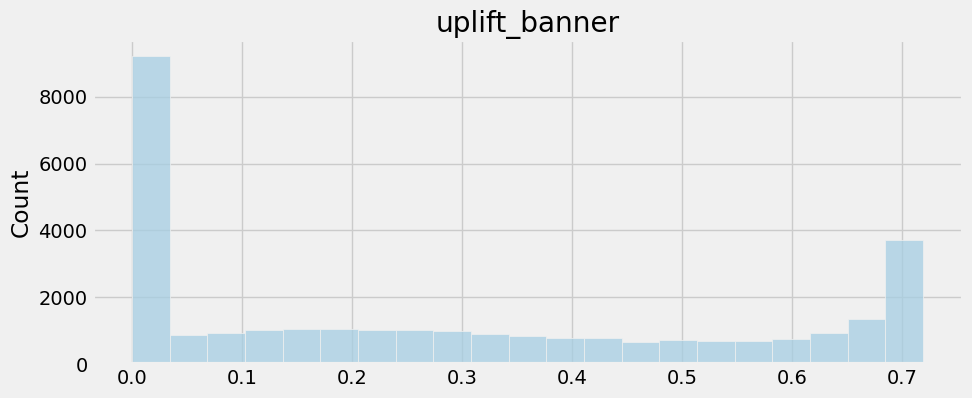

In [746]:
uplift_pd = pd.DataFrame(data = uplift_banner, index = X_test_banner.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(data = uplift_pd, x=uplift_banner).set_title('uplift_banner')
plt.show()

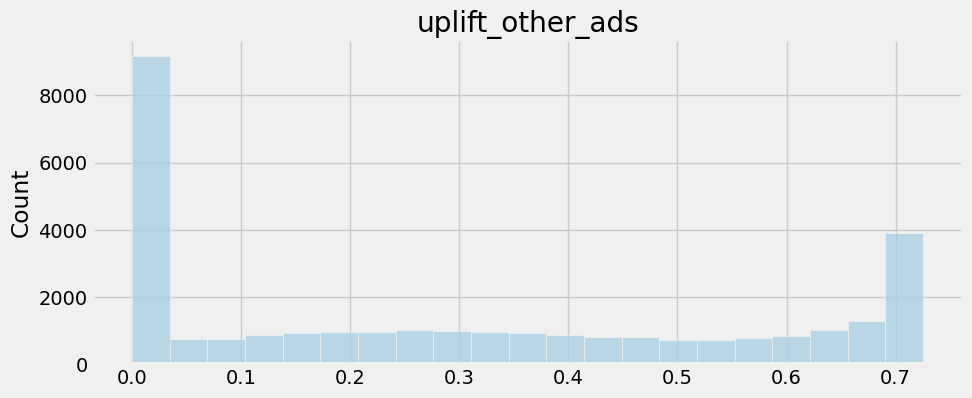

In [747]:
uplift_pd = pd.DataFrame(data = uplift_other_ads, index = X_test_other_ads.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(data = uplift_pd, x=uplift_other_ads).set_title('uplift_other_ads')
plt.show()

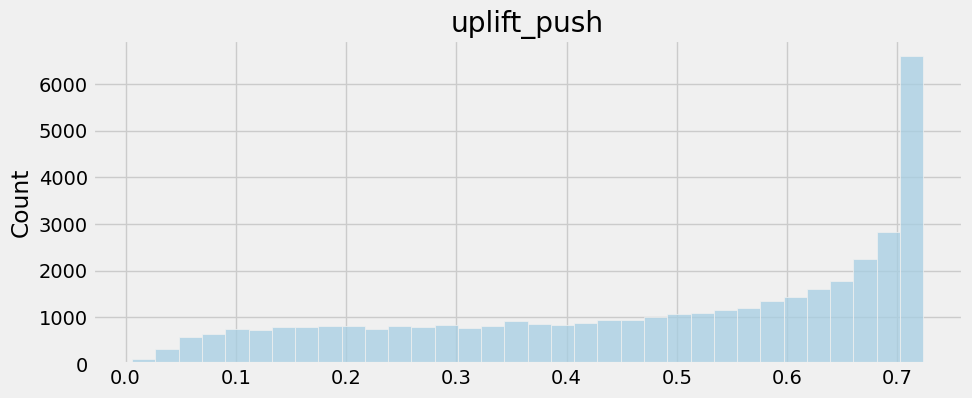

In [748]:
uplift_pd = pd.DataFrame(data = uplift_push, index = X_test_push.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(data = uplift_pd, x=uplift_push).set_title('uplift_push')
plt.show()

In [749]:
results_banner = X_test_banner[['channel', 'user_id']].copy()
results_banner['uplift'] = uplift_banner

results_other_ads = X_test_other_ads[['channel', 'user_id']].copy()
results_other_ads['uplift'] = uplift_other_ads

results_push = X_test_push[['channel', 'user_id']].copy()
results_push['uplift'] = uplift_push

results_solo = pd.concat([results_banner, results_other_ads, results_push], ignore_index=True)

In [ ]:
results_solo.to_csv("results_solo.csv", index=False, encoding="utf-8")

In [750]:
from sklift.metrics import weighted_average_uplift


uplift_full_data = weighted_average_uplift(y_test_banner, uplift_banner,
                                           X_test_banner['t_flag'], bins=10)
print(f"weighted average uplift on full data: {uplift_full_data:.4f}")

weighted average uplift on full data: 0.2838


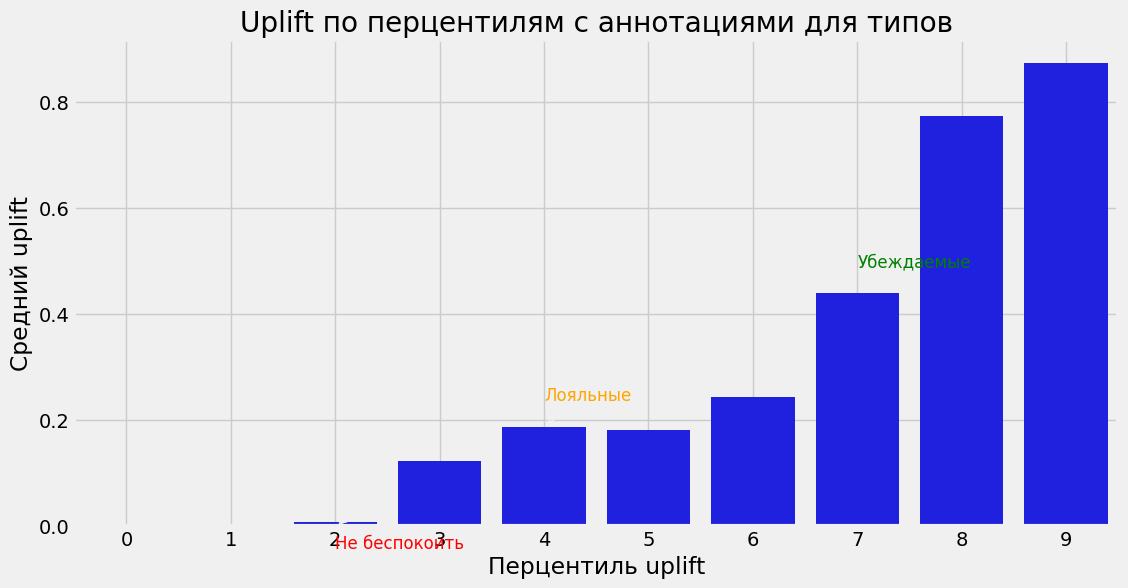

In [751]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Пример данных (предположительно, вы их уже подготовили)
df = X_test_banner.copy()
df['uplift'] = uplift_banner
df['target'] = y_test_banner
df['t_flag'] = X_test_banner['t_flag']

# Разбиение по перцентилям
df['uplift_percentile'] = pd.qcut(df['uplift'], q=10, labels=False)

# Группировка по перцентилям и t_flag
uplift_by_percentile = df.groupby(['uplift_percentile', 't_flag'])['target'].mean().unstack()

# Рассчитываем uplift
uplift_by_percentile['uplift'] = uplift_by_percentile[1] - uplift_by_percentile[0]

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(x=uplift_by_percentile.index, y=uplift_by_percentile['uplift'], color='b')

# Линия для разделения типов
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Аннотации для типов: Убеждаемые, Лояльные, Не беспокоить
plt.annotate('Убеждаемые', xy=(7, uplift_by_percentile['uplift'][7]), xytext=(7, uplift_by_percentile['uplift'][7] + 0.05),
             arrowprops=dict(arrowstyle='->', lw=1), fontsize=12, color='green')
plt.annotate('Лояльные', xy=(4, uplift_by_percentile['uplift'][4]), xytext=(4, uplift_by_percentile['uplift'][4] + 0.05),
             arrowprops=dict(arrowstyle='->', lw=1), fontsize=12, color='orange')
plt.annotate('Не беспокоить', xy=(2, uplift_by_percentile['uplift'][2]), xytext=(2, uplift_by_percentile['uplift'][2] - 0.05),
             arrowprops=dict(arrowstyle='->', lw=1), fontsize=12, color='red')

# Настройка осей и заголовка
plt.xlabel('Перцентиль uplift')
plt.ylabel('Средний uplift')
plt.title('Uplift по перцентилям с аннотациями для типов')

# Настройка сетки
plt.grid(True)
plt.show()


## Подход Solomodel без дополнительных библиотек и калибровок

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [752]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     cross_validate,
                                     StratifiedKFold)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier

import optuna

from catboost import CatBoostClassifier

from sklift.models import (SoloModel,
                           TwoModels,
                           ClassTransformation,
                           ClassTransformationReg)
from sklift.metrics import (uplift_at_k,
                            uplift_auc_score,
                            qini_auc_score,
                            make_uplift_scorer)
from sklift.viz import plot_qini_curve, plot_uplift_curve

In [753]:
sm_banner = SoloModel(estimator=model)
sm_banner.fit(X_train_banner_filtered.drop(columns=['t_flag','age_scaled','city_encoded2']),
       y_train_banner,
       treatment=X_train_banner_filtered['t_flag'])
uplift_sm_banner = sm_banner.predict(X_test_banner_filtered.drop(columns=['t_flag','age_scaled','city_encoded2']))

sm_other_ads = SoloModel(estimator=model)
sm_other_ads.fit(X_train_other_ads_filtered.drop(columns='t_flag'),
       y_train_other_ads,
       treatment=X_train_other_ads_filtered['t_flag'])
uplift_sm_other_ads = sm_other_ads.predict(X_test_other_ads_filtered.drop(columns='t_flag'))

sm_push = SoloModel(estimator=model)
sm_push.fit(X_train_push_filtered.drop(columns='t_flag'),
       y_train_push,
       treatment=X_train_push_filtered['t_flag'])
uplift_sm_push = sm_push.predict(X_test_push_filtered.drop(columns='t_flag'))

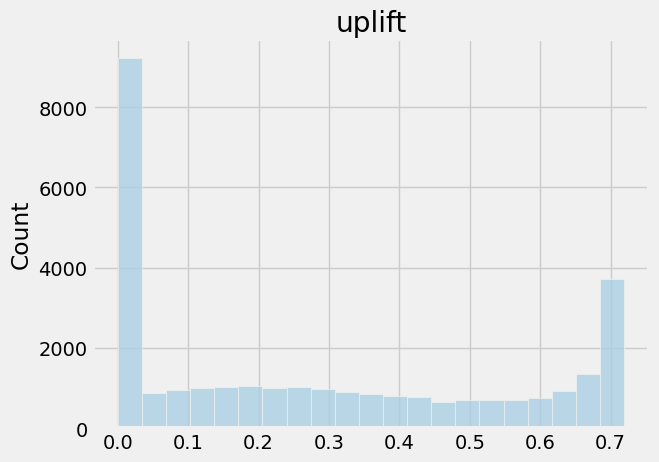

In [754]:
uplift_pd = pd.DataFrame(data = uplift_sm_banner, index = X_test_banner_filtered.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_banner).set_title('uplift')
plt.show()

In [755]:
print(np.linalg.norm(uplift_banner - uplift_sm_banner) / np.linalg.norm(uplift_sm_banner))
print(np.linalg.norm(uplift_other_ads - uplift_sm_other_ads) / np.linalg.norm(uplift_sm_other_ads))
print(np.linalg.norm(uplift_push - uplift_sm_push) / np.linalg.norm(uplift_sm_push))

0.00543362599639815
0.0011049027118336767
5.616784721177599e-05


In [756]:
uplift_banner

array([3.24039055e-01, 1.43220733e-07, 1.74630451e-03, ...,
       8.32993752e-02, 4.72479497e-01, 9.03795106e-05])

получилось качество Uplift дял разных компаний

In [757]:
print(uplift_at_k(y_true=y_test_banner,
            uplift=uplift_sm_banner,
            treatment=X_test_banner_filtered['t_flag'],
            strategy='by_group',
            k=0.2))
print(uplift_at_k(y_true=y_test_other_ads,
            uplift=uplift_sm_other_ads,
            treatment=X_test_other_ads_filtered['t_flag'],
            strategy='by_group',
            k=0.2))
print(uplift_at_k(y_true=y_test_push,
            uplift=uplift_sm_push,
            treatment=X_test_push_filtered['t_flag'],
            strategy='by_group',
            k=0.2))

0.826353384052006
0.8236666666666667
0.7211896217557671


In [758]:
print(uplift_auc_score(y_true=y_test_banner,
                 uplift=uplift_sm_banner,
                 treatment=X_test_banner_filtered['t_flag']))
print(uplift_auc_score(y_true=y_test_other_ads,
                 uplift=uplift_sm_other_ads,
                 treatment=X_test_other_ads_filtered['t_flag']))
print(uplift_auc_score(y_true=y_test_push,
                 uplift=uplift_sm_push,
                 treatment=X_test_push_filtered['t_flag']))

0.3291662708789649
0.3369061527998332
0.2713504666027745


In [790]:
print(qini_auc_score(y_true=y_test_banner,
               uplift=pd.Series(uplift_sm_banner, index=X_test_banner_filtered.index),
               treatment=X_test_banner_filtered['t_flag']))
print(qini_auc_score(y_true=y_test_other_ads,
               uplift=pd.Series(uplift_sm_other_ads, index=X_test_other_ads_filtered.index),
               treatment=X_test_other_ads_filtered['t_flag']))
print(qini_auc_score(y_true=y_test_push,
               uplift=pd.Series(uplift_sm_push, index=X_test_push_filtered.index),
               treatment=X_test_push_filtered['t_flag']))

0.205951887185249
0.20643886181493365
0.1619610132929095


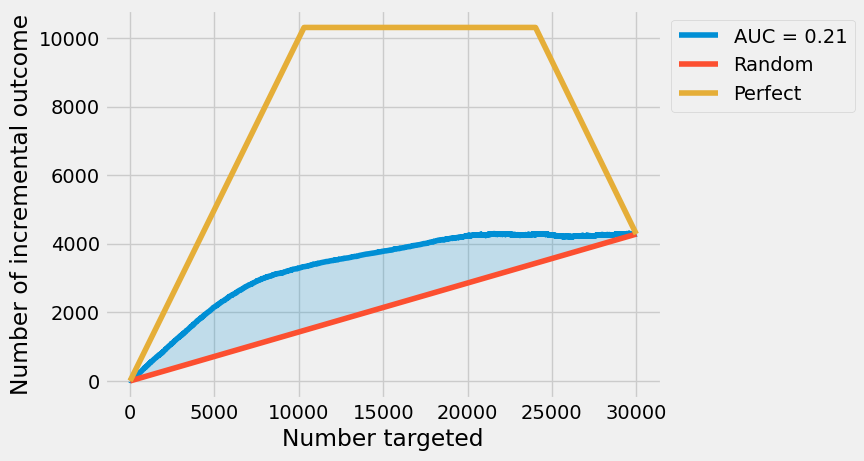

In [ ]:
plot_qini_curve(y_test_banner, pd.Series(uplift_sm_banner, index=X_test_banner_filtered.index), X_test_banner_filtered['t_flag'])   

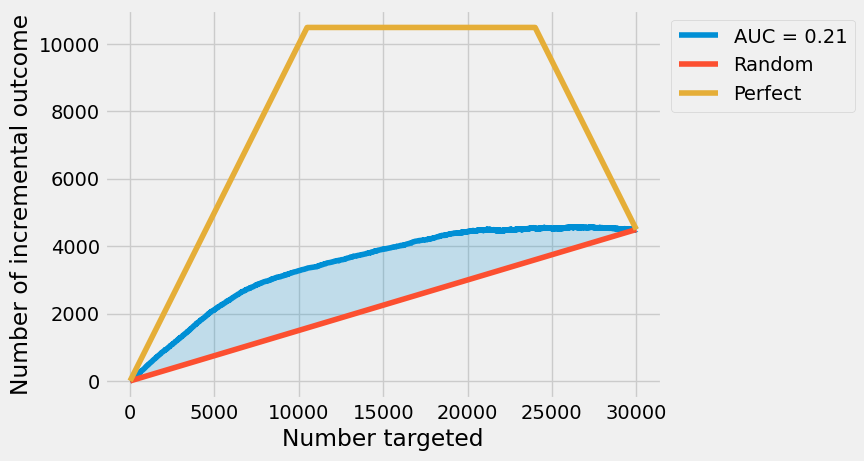

In [797]:
plot_qini_curve(y_test_other_ads, pd.Series(uplift_sm_other_ads, index=X_test_other_ads.index), X_test_other_ads['t_flag'])   

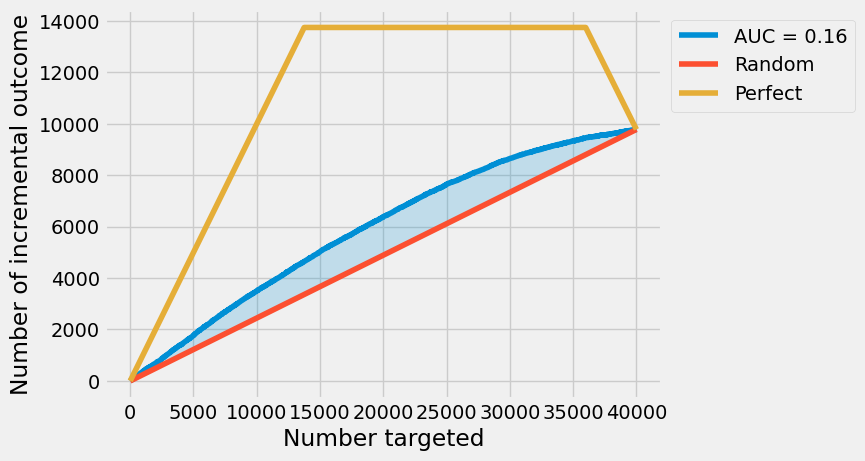

In [823]:
plot_qini_curve(y_test_push, pd.Series(uplift_sm_push, index=X_test_push_filtered.index), X_test_push_filtered['t_flag'])   

## Подход Twomodel через Sklift

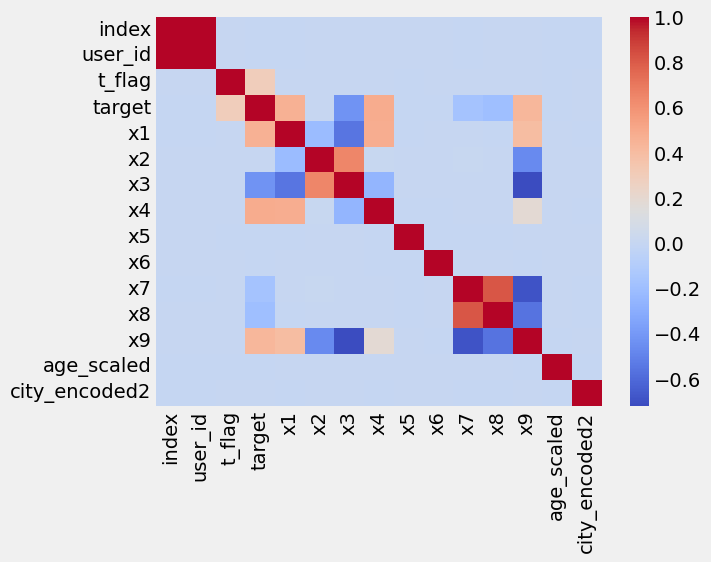

In [799]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = banner_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

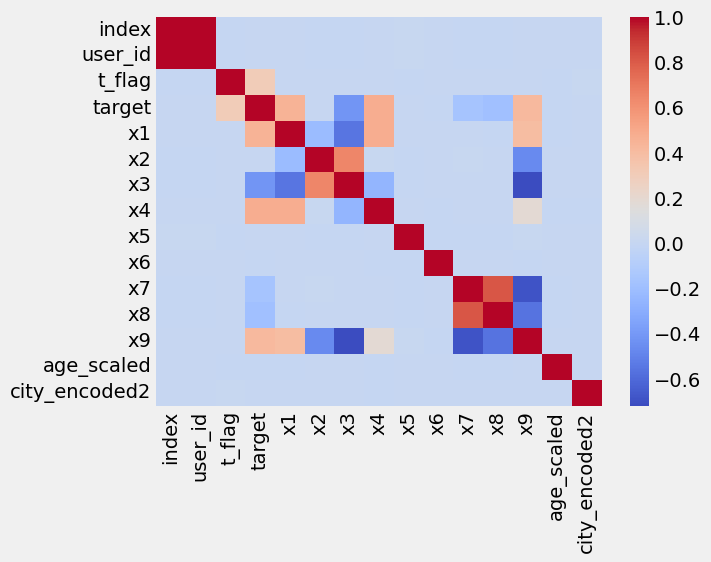

In [800]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = other_ads_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

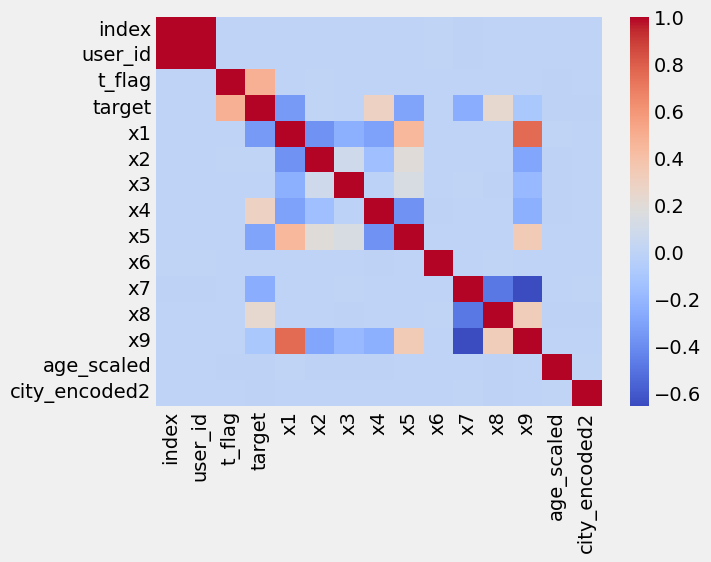

In [801]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = push_df_recovered.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

Корреляция есть! Класс!

Qini AUC Score (Two Models): 0.2231
0    0.500744
1    0.499256
Name: t_flag, dtype: float64
Chi2 test p-value: 0.0


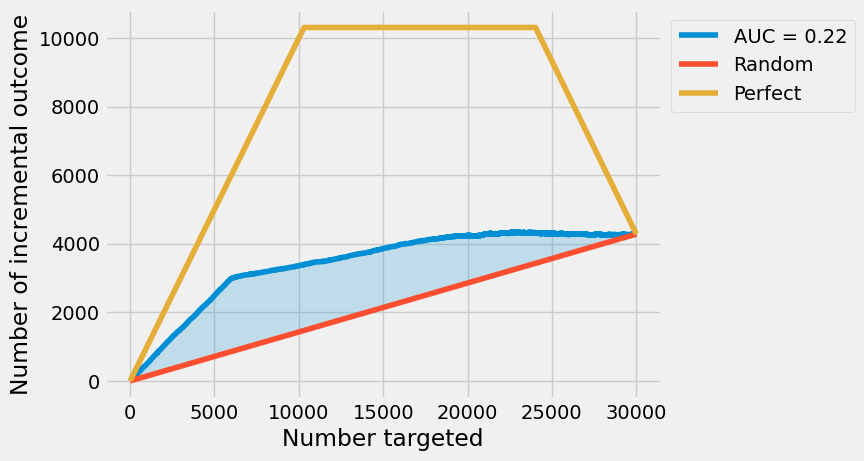

In [802]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklift.models import TwoModels, ClassTransformation
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


# === Метод "Two Models" ===
model_1 = LogisticRegression(random_state=42)
model_2 = LogisticRegression(random_state=43)

treatment_test=X_test_banner_filtered['t_flag']

tm_model = TwoModels(estimator_trmnt=model_1, estimator_ctrl=model_2, method='ddr_control')
tm_model.fit(X_train_banner_filtered.drop(columns='t_flag'), y_train_banner, treatment=X_train_banner_filtered['t_flag'])
uplift_tm = tm_model.predict(X_test_banner_filtered.drop(columns='t_flag'))

# === Оценка качества модели ===
_qini_score = qini_auc_score(y_test_banner, uplift_tm, treatment_test)
print(f"Qini AUC Score (Two Models): {_qini_score:.4f}")

# === Альтернативная модель "Class Transformation" ===
#ct_model = ClassTransformation(LogisticRegression(random_state=42))
#ct_model.fit(X_train_banner_filtered.drop(columns='t_flag'), y_train_banner, treatment=X_train_banner_filtered['t_flag'])
#uplift_ct = ct_model.predict(X_test_banner_filtered.drop(columns='t_flag'))

#qini_ct_score = qini_auc_score(y_test_banner, uplift_ct, treatment_test)
#print(f"Qini AUC Score (Class Transformation): {qini_ct_score:.4f}")

# === Визуализация Qini-кривой ===
plot_qini_curve(y_test_banner, pd.Series(uplift_tm, index=X_test_banner_filtered.index), treatment_test)
print(X_train_banner['t_flag'].value_counts(normalize=True))

from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(X_train_banner['t_flag'], y_train_banner)
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi2 test p-value: {p}")

Qini AUC Score (Two Models): 0.2202
1    0.5
0    0.5
Name: t_flag, dtype: float64
Chi2 test p-value: 0.0


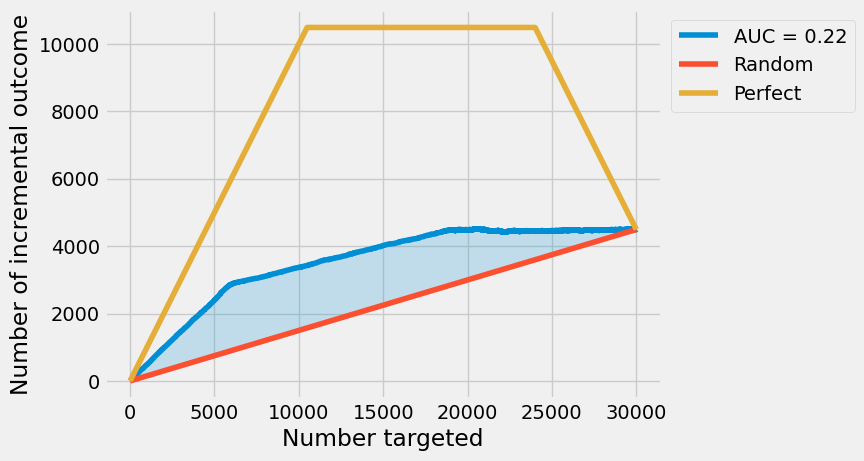

In [803]:
treatment_test=X_test_other_ads_filtered['t_flag']

tm_model = TwoModels(estimator_trmnt=model_1, estimator_ctrl=model_2, method='vanilla')
tm_model.fit(X_train_other_ads_filtered.drop(columns='t_flag'), y_train_other_ads, treatment=X_train_other_ads_filtered['t_flag'])
uplift_tm = tm_model.predict(X_test_other_ads_filtered.drop(columns='t_flag'))

# === Оценка качества модели ===
_qini_score = qini_auc_score(y_test_other_ads, uplift_tm, treatment_test)
print(f"Qini AUC Score (Two Models): {_qini_score:.4f}")

# === Альтернативная модель "Class Transformation" ===
#ct_model = ClassTransformation(LogisticRegression(random_state=42))
#ct_model.fit(X_train_other_ads_filtered.drop(columns='t_flag'), y_train_other_ads, treatment=X_train_other_ads_filtered['t_flag'])
#uplift_ct = ct_model.predict(X_test_other_ads_filtered.drop(columns='t_flag'))

#qini_ct_score = qini_auc_score(y_test_other_ads, uplift_ct, treatment_test)
#print(f"Qini AUC Score (Class Transformation): {qini_ct_score:.4f}")

# === Визуализация Qini-кривой ===
plot_qini_curve(y_test_other_ads, pd.Series(uplift_tm, index=X_test_other_ads.index), treatment_test)
print(X_train_other_ads['t_flag'].value_counts(normalize=True))

from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(X_train_other_ads['t_flag'], y_train_other_ads)
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi2 test p-value: {p}")

Qini AUC Score (Two Models): 0.3230
1    0.5009
0    0.4991
Name: t_flag, dtype: float64
Chi2 test p-value: 0.0


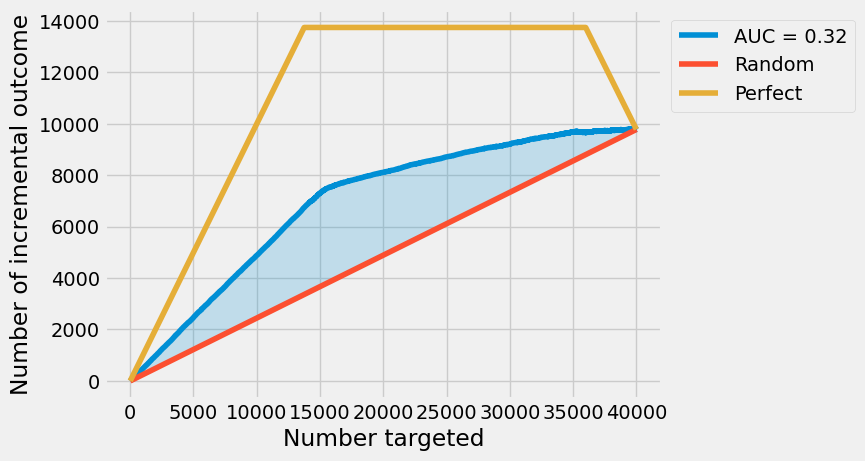

In [822]:
treatment_test=X_test_push_filtered['t_flag']

tm_model = TwoModels(estimator_trmnt=model_1, estimator_ctrl=model_2, method='vanilla')
tm_model.fit(X_train_push_filtered.drop(columns='t_flag'), y_train_push, treatment=X_train_push_filtered['t_flag'])
uplift_tm = tm_model.predict(X_test_push_filtered.drop(columns='t_flag'))

# === Оценка качества модели ===
qini_score = qini_auc_score(y_test_push, uplift_tm, treatment_test)
print(f"Qini AUC Score (Two Models): {qini_score:.4f}")

# === Альтернативная модель "Class Transformation" ===
#ct_model = ClassTransformation(LogisticRegression(random_state=42))
#ct_model.fit(X_train_push_filtered.drop(columns='t_flag'), y_train_push, treatment=X_train_push_filtered['t_flag'])
#uplift_ct = ct_model.predict(X_test_push_filtered.drop(columns='t_flag'))

#qini_ct_score = qini_auc_score(y_test_push, uplift_ct, treatment_test)
#print(f"Qini AUC Score (Class Transformation): {qini_ct_score:.4f}")

# === Визуализация Qini-кривой ===
plot_qini_curve(y_test_push, pd.Series(uplift_tm, index=X_test_push.index), treatment_test)
print(X_train_push['t_flag'].value_counts(normalize=True))

from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(X_train_push['t_flag'], y_train_push)
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi2 test p-value: {p}")

## the best practice

In [824]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklift.models import TwoModels, ClassTransformation

In [807]:
X_train = X_train_banner_filtered.drop(columns='t_flag')
X_test = X_test_banner_filtered.drop(columns='t_flag')
y_train = y_train_banner
y_test = y_test_banner
treatment_train = X_train_banner_filtered['t_flag']
treatment_test = X_test_banner_filtered['t_flag']

In [808]:
treatment_train = treatment_train.astype('int')
treatment_test = treatment_test.astype('int')

In [809]:
uplift_forest = UpliftRandomForestClassifier(control_name='0',
                                             random_state=RANDOM_STATE)

X_train_banner_filtered['t_flag'] = X_train_banner_filtered['t_flag'].astype('str')
X_train_banner_filtered['t_flag'] = X_train_banner_filtered['t_flag'].astype('str')

uplift_forest.fit(X=X_train_banner_filtered.drop(columns='t_flag').values,
                  y=y_train_banner.values,
                  treatment=X_train_banner_filtered['t_flag'].values)

uplift_fr = uplift_forest.predict(X=X_test_banner_filtered.drop(columns='t_flag').values)

qini_auc_score(y_true=y_test_banner,
                 uplift=uplift_fr.reshape(-1),
                 treatment=X_test_banner_filtered['t_flag'].astype('int'))

0.1925523672545021

In [827]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
import numpy as np

class SLearner(BaseEstimator, RegressorMixin):
    def __init__(self, base_model):
        """
        Инициализация S-learner.
        
        :param base_model: Базовая модель (например, RandomForestRegressor).
        """
        self.base_model = base_model

    def fit(self, X, y, treatment):
        """
        Обучение S-learner.
        
        :param X: Матрица признаков.
        :param y: Исходная целевая переменная.
        :param treatment: Вектор лечения (1 — лечение, 0 — контроль).
        """
        # Добавляем treatment как дополнительный признак
        X_with_treatment = np.column_stack((X, treatment))
        
        # Обучаем модель
        self.base_model.fit(X_with_treatment, y)
        return self

    def predict(self, X):
        """
        Предсказание uplift.
        
        :param X: Матрица признаков.
        :return: Предсказанный uplift.
        """
        # Предсказание для treatment = 1
        X_treatment = np.column_stack((X, np.ones(X.shape[0])))
        y_treatment = self.base_model.predict(X_treatment)
        
        # Предсказание для treatment = 0
        X_control = np.column_stack((X, np.zeros(X.shape[0])))
        y_control = self.base_model.predict(X_control)
        
        # Uplift = разница между treatment и control
        return y_treatment - y_control


class TLearner(BaseEstimator, RegressorMixin):
    def __init__(self, base_model_control, base_model_treatment):
        """
        Инициализация T-learner.
        
        :param base_model_control: Базовая модель для контрольной группы.
        :param base_model_treatment: Базовая модель для тестовой группы.
        """
        self.base_model_control = base_model_control
        self.base_model_treatment = base_model_treatment

    def fit(self, X, y, treatment):
        """
        Обучение T-learner.
        
        :param X: Матрица признаков.
        :param y: Исходная целевая переменная.
        :param treatment: Вектор лечения (1 — лечение, 0 — контроль).
        """
        # Обучаем модель для контрольной группы
        self.base_model_control.fit(X[treatment == 0], y[treatment == 0])
        
        # Обучаем модель для тестовой группы
        self.base_model_treatment.fit(X[treatment == 1], y[treatment == 1])
        return self

    def predict(self, X):
        """
        Предсказание uplift.
        
        :param X: Матрица признаков.
        :return: Предсказанный uplift.
        """
        # Предсказание для тестовой группы
        y_treatment = self.base_model_treatment.predict(X)
        
        # Предсказание для контрольной группы
        y_control = self.base_model_control.predict(X)
        
        # Uplift = разница между treatment и control
        return y_treatment - y_control


class ClassTransformationClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier):
        """
        Инициализация Class Transformation.
        
        :param base_classifier: Базовая модель классификации (например, RandomForestClassifier).
        """
        self.base_classifier = base_classifier

    def fit(self, X, y, treatment):
        """
        Обучение Class Transformation.
        
        :param X: Матрица признаков.
        :param y: Исходная целевая переменная.
        :param treatment: Вектор лечения (1 — лечение, 0 — контроль).
        """
        # Преобразование целевой переменной
        self.classes_ = np.unique(y)
        Z = y * (2 * treatment - 1)
        
        # Обучение базовой модели
        self.base_classifier.fit(X, Z)
        return self

    def predict_proba(self, X):
        """
        Предсказание вероятностей.
        
        :param X: Матрица признаков.
        :return: Вероятности классов.
        """
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        """
        Предсказание uplift.
        
        :param X: Матрица признаков.
        :return: Предсказанный uplift.
        """
        proba = self.predict_proba(X)
        return proba[:, 1] - proba[:, 0]


class UpliftModel:
    def __init__(self, method="slearner", base_model=None, base_model_control=None, base_model_treatment=None):
        """
        Инициализация UpliftModel.
        
        :param method: Метод uplift-моделирования ("slearner", "tlearner", "class_transformation").
        :param base_model: Базовая модель для S-learner или Class Transformation.
        :param base_model_control: Базовая модель для контрольной группы (T-learner).
        :param base_model_treatment: Базовая модель для тестовой группы (T-learner).
        """
        self.method = method
        self.base_model = base_model
        self.base_model_control = base_model_control
        self.base_model_treatment = base_model_treatment

        if method == "slearner":
            self.model = SLearner(base_model=base_model)
        elif method == "tlearner":
            self.model = TLearner(base_model_control=base_model_control, base_model_treatment=base_model_treatment)
        elif method == "class_transformation":
            self.model = ClassTransformationClassifier(base_classifier=base_model)
        else:
            raise ValueError("Неизвестный метод. Доступные методы: 'slearner', 'tlearner', 'class_transformation'.")

    def fit(self, X, y, treatment):
        """
        Обучение модели.
        
        :param X: Матрица признаков.
        :param y: Исходная целевая переменная.
        :param treatment: Вектор лечения (1 — лечение, 0 — контроль).
        """
        self.model.fit(X, y, treatment)
        return self

    def predict(self, X):
        """
        Предсказание uplift.
        
        :param X: Матрица признаков.
        :return: Предсказанный uplift.
        """
        return self.model.predict(X)

In [828]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

def objective(trial):
    # Выбираем гиперпараметры
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", 0.5, 0.8])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 100, step=10)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.1)

    # Выбираем метод (например, "slearner", "tlearner", "class_transformation")
    method = trial.suggest_categorical("method", ["slearner", "tlearner", "class_transformation"])

    # Создаём базовые модели
    if method == "slearner":
        base_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            max_features=max_features,
            bootstrap=bootstrap,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42
        )
        uplift_model = UpliftModel(method=method, base_model=base_model)
    elif method == "tlearner":
        base_model_control = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            max_features=max_features,
            bootstrap=bootstrap,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42
        )
        base_model_treatment = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            max_features=max_features,
            bootstrap=bootstrap,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42
        )
        uplift_model = UpliftModel(method=method, base_model_control=base_model_control, base_model_treatment=base_model_treatment)
    elif method == "class_transformation":
        base_model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            max_features=max_features,
            bootstrap=bootstrap,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42
        )
        uplift_model = UpliftModel(method=method, base_model=base_model)

    # Обучение модели
    uplift_model.fit(
        X=X_train.drop(columns='t_flag').values,
        y=y_train.values,
        treatment=X_train['t_flag'].astype(int).values
    )

    # Предсказания uplift
    uplift_preds = uplift_model.predict(
        X=X_test.drop(columns='t_flag').values
    )

    # Метрика Qini
    qini_score = qini_auc_score(
        y_true=y_test,
        uplift=uplift_preds,
        treatment=X_test['t_flag'].astype(int)
    )

    return qini_score

In [611]:
X_train= X_train_banner_filtered
y_train = y_train_banner
X_test = X_test_banner_filtered
y_test = y_test_banner

study_banner = optuna.create_study(direction="maximize")  # Оптимизируем Qini AUC (максимизация)
study_banner.optimize(objective, n_trials=50)  # Количество итераций поиска

X_train= X_train_other_ads_filtered
y_train = y_train_other_ads
X_test = X_test_other_ads_filtered
y_test = y_test_other_ads

study_other_ads = optuna.create_study(direction="maximize")  # Оптимизируем Qini AUC (максимизация)
study_other_ads.optimize(objective, n_trials=50)  # Количество итераций поиска

X_train= X_train_push_filtered
y_train = y_train_push
X_test = X_test_push_filtered
y_test = y_test_push

study_push = optuna.create_study(direction="maximize")  # Оптимизируем Qini AUC (максимизация)
study_push.optimize(objective, n_trials=50)  # Количество итераций поиска

[I 2025-02-24 18:09:28,576] A new study created in memory with name: no-name-39f1c4b3-9d23-43ca-a59b-6ecbf893efa3
[I 2025-02-24 18:09:52,896] Trial 0 finished with value: 0.12266772971106922 and parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 19, 'max_features': 'sqrt', 'bootstrap': True, 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.07804740103598656, 'method': 'class_transformation'}. Best is trial 0 with value: 0.12266772971106922.
[I 2025-02-24 18:10:07,530] Trial 1 finished with value: 0.13439662443597022 and parameters: {'n_estimators': 250, 'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 6, 'max_features': 'sqrt', 'bootstrap': True, 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.05470869116738395, 'method': 'class_transformation'}. Best is trial 1 with value: 0.13439662443597022.
[I 2025-02-24 18:10:36,649] Trial 2 finished with value: 0.07050260900923189 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_s

In [833]:
X_train= X_train_push_filtered
y_train = y_train_push
X_test = X_test_push_filtered
y_test = y_test_push

study_push = optuna.create_study(direction="maximize")  # Оптимизируем Qini AUC (максимизация)
study_push.optimize(objective, n_trials=50)  # Количество итераций поиска

[I 2025-02-25 13:44:04,842] A new study created in memory with name: no-name-d8332e35-32bb-49a5-bc59-b35c711e1004
[I 2025-02-25 13:44:29,142] Trial 0 finished with value: -0.04864391525689582 and parameters: {'n_estimators': 150, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 10, 'max_features': 'auto', 'bootstrap': True, 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.034969803570391866, 'method': 'class_transformation'}. Best is trial 0 with value: -0.04864391525689582.
[I 2025-02-25 13:47:28,359] Trial 1 finished with value: 0.28648514546310716 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 10, 'max_features': 0.8, 'bootstrap': True, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.017113742008114274, 'method': 'slearner'}. Best is trial 1 with value: 0.28648514546310716.
[I 2025-02-25 13:49:29,456] Trial 2 finished with value: -0.026835678282484787 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_lea

In [829]:
# Получаем лучшие параметры
best_params = study_banner.best_params
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_leaf = best_params['min_samples_leaf']
best_method = best_params['method']

print(f"Лучшие параметры study_banner: {best_params}")

Лучшие параметры study_banner: {'n_estimators': 150, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 0.8, 'bootstrap': False, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.0003258331638408712, 'method': 'tlearner'}


Qini AUC Score (Best Model): 0.2254


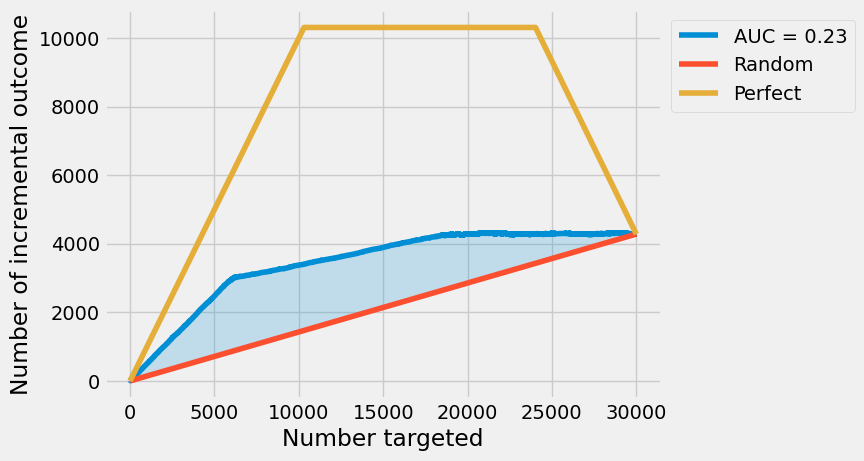

In [830]:
# Создаём финальную модель с лучшими параметрами
if best_method == "slearner":
    best_model_banner = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_banner = UpliftModel(method=best_method, base_model=best_model_banner)
elif best_method == "tlearner":
    best_model_control = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    best_model_treatment = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_banner = UpliftModel(method=best_method, base_model_control=best_model_control, base_model_treatment=best_model_treatment)
elif best_method == "class_transformation":
    best_model_banner = RandomForestClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_banner = UpliftModel(method=best_method, base_model=best_model_banner)

# Обучение финальной модели
uplift_model_banner.fit(
    X=X_train_banner_filtered.drop(columns='t_flag').values,
    y=y_train_banner.values,
    treatment=X_train_banner_filtered['t_flag'].astype(int).values
)

# Предсказания uplift
uplift_preds_banner_best = uplift_model_banner.predict(
    X=X_test_banner_filtered.drop(columns='t_flag').values
)

# Оценка качества модели
treatment_test = X_test_banner_filtered['t_flag'].astype(int)
_qini_score = qini_auc_score(y_test_banner, uplift_preds_banner_best, treatment_test)
print(f"Qini AUC Score (Best Model): {_qini_score:.4f}")

# Визуализация Qini-кривой
plot_qini_curve(
    y_true=y_test_banner,
    uplift=pd.Series(uplift_preds_banner_best, index=X_test_banner_filtered.index),
    treatment=treatment_test
)

In [831]:
# Получаем лучшие параметры
best_params = study_other_ads.best_params
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_leaf = best_params['min_samples_leaf']
best_method = best_params['method']

print(f"Лучшие параметры other_ads: {best_params}")

Лучшие параметры other_ads: {'n_estimators': 400, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 14, 'max_features': 0.8, 'bootstrap': True, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.0001185963117165277, 'method': 'tlearner'}


Qini AUC Score (Best Model): 0.2240


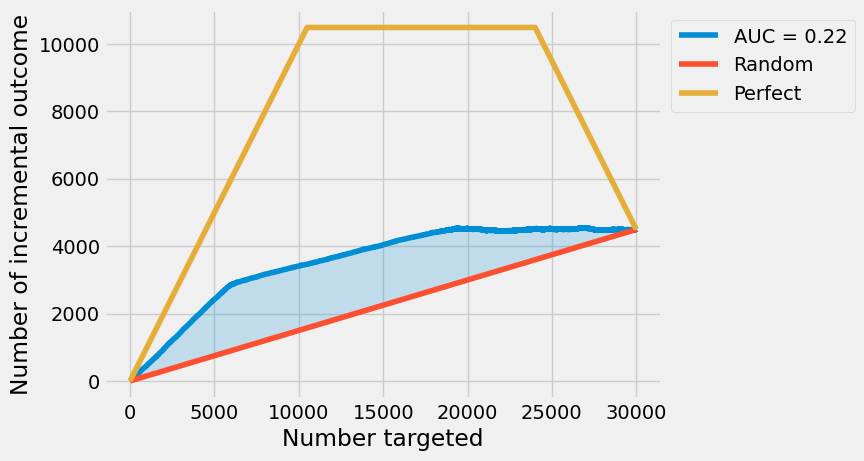

In [832]:
# Создаём финальную модель с лучшими параметрами
if best_method == "slearner":
    best_model_other_ads = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_other_ads = UpliftModel(method=best_method, base_model=best_model_other_ads)
elif best_method == "tlearner":
    best_model_control = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    best_model_treatment = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_other_ads = UpliftModel(method=best_method, base_model_control=best_model_control, base_model_treatment=best_model_treatment)
elif best_method == "class_transformation":
    best_model_other_ads = RandomForestClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_other_ads = UpliftModel(method=best_method, base_model=best_model_other_ads)

# Обучение финальной модели
uplift_model_other_ads.fit(
    X=X_train_other_ads_filtered.drop(columns='t_flag').values,
    y=y_train_other_ads.values,
    treatment=X_train_other_ads_filtered['t_flag'].astype(int).values
)

# Предсказания uplift
uplift_preds_other_ads_best = uplift_model_other_ads.predict(
    X=X_test_other_ads_filtered.drop(columns='t_flag').values
)

# Оценка качества модели
treatment_test = X_test_other_ads_filtered['t_flag'].astype(int)
_qini_score = qini_auc_score(y_test_other_ads, uplift_preds_other_ads_best, treatment_test)
print(f"Qini AUC Score (Best Model): {_qini_score:.4f}")

# Визуализация Qini-кривой
plot_qini_curve(
    y_true=y_test_other_ads,
    uplift=pd.Series(uplift_preds_other_ads_best, index=X_test_other_ads_filtered.index),
    treatment=treatment_test
)

In [834]:
# Получаем лучшие параметры
best_params = study_push.best_params
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_leaf = best_params['min_samples_leaf']
best_method = best_params['method']

print(f"Лучшие параметры push: {best_params}")

Лучшие параметры push: {'n_estimators': 400, 'max_depth': 18, 'min_samples_leaf': 4, 'min_samples_split': 5, 'max_features': 0.5, 'bootstrap': True, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.00012424746730949635, 'method': 'tlearner'}


Qini AUC Score (Best Model): 0.3324


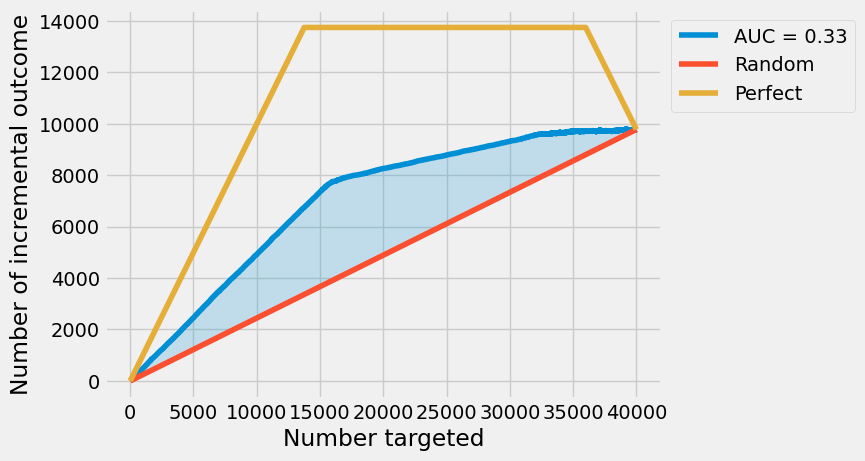

In [835]:
# Создаём финальную модель с лучшими параметрами
if best_method == "slearner":
    best_model_push = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_push = UpliftModel(method=best_method, base_model=best_model_push)
elif best_method == "tlearner":
    best_model_control = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    best_model_treatment = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_push = UpliftModel(method=best_method, base_model_control=best_model_control, base_model_treatment=best_model_treatment)
elif best_method == "class_transformation":
    best_model_push = RandomForestClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    uplift_model_push = UpliftModel(method=best_method, base_model=best_model_push)

# Обучение финальной модели
uplift_model_push.fit(
    X=X_train_push_filtered.drop(columns='t_flag').values,
    y=y_train_push.values,
    treatment=X_train_push_filtered['t_flag'].astype(int).values
)

# Предсказания uplift
uplift_preds_push_best = uplift_model_push.predict(
    X=X_test_push_filtered.drop(columns='t_flag').values
)

# Оценка качества модели
treatment_test = X_test_push_filtered['t_flag'].astype(int)
_qini_score = qini_auc_score(y_test_push, uplift_preds_push_best, treatment_test)
print(f"Qini AUC Score (Best Model): {_qini_score:.4f}")

# Визуализация Qini-кривой
plot_qini_curve(
    y_true=y_test_push,
    uplift=pd.Series(uplift_preds_push_best, index=X_test_push_filtered.index),
    treatment=treatment_test
)

Готовим скоринг

In [ ]:
scoring_user_data_01 = scoring_user_data_01.drop(columns=['Unnamed: 0'])
scoring_user_data_01 = scoring_user_data_01.drop(columns=['report_dt'])

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [877]:
# === Кастомный Label Encoder для Pipeline ===
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoder = LabelEncoder()
        self.encoder.fit(X.squeeze())  # Преобразуем в одномерный массив
        return self

    def transform(self, X):
        return self.encoder.transform(X.squeeze()).reshape(-1, 1)

# === Функция для преобразования user_id в int ===
def convert_user_id_to_int(X):
    return X.astype(int)

# === Определяем ColumnTransformer ===
preprocessor = ColumnTransformer(
    transformers=[
        ('city', CustomLabelEncoder(), ['city']),  # Кодируем city
        ('age', StandardScaler(), ['age']),  # Масштабируем age
        ('user_id', FunctionTransformer(convert_user_id_to_int, validate=False), ['user_id'])  # user_id -> int
    ],
    remainder='passthrough'  # Оставляем x1-x9 без изменений
)

# === Определяем Pipeline ===
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# === Применяем пайплайн ===
df_transformed = pipeline.fit_transform(scoring_user_data_01)

# === Приводим обратно в DataFrame ===
df_transformed = pd.DataFrame(df_transformed, columns=[
    'city_encoded', 'age_scaled', 'user_id', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'
])
df_transformed['city_encoded2'] = scaler.fit_transform(df_transformed[['city_encoded']])
df_transformed = df_transformed.drop(columns=['city_encoded'])
# === Выводим итоговый DataFrame ===
predict_data = df_transformed.drop(columns=['user_id'], errors='ignore')

In [879]:
# Предсказания uplift
uplift_preds_banner_best = uplift_model_banner.predict(
    X=predict_data.values
)
# Предсказания uplift
uplift_preds_other_ads_best = uplift_model_other_ads.predict(
    X=predict_data.values
)
# Предсказания uplift
uplift_preds_push_best = uplift_model_push.predict(
    X=predict_data.values
)

In [885]:
predict_data['report_dt'] = pd.to_datetime('2025-01-31')
predict_data['user_id'] = df_transformed['user_id'].values  # добавляем user_id
predict_data['uplift_banner'] = uplift_preds_banner_best  # добавляем uplift
predict_data['uplift_other_ads'] = uplift_preds_other_ads_best  # добавляем uplift
predict_data['uplift_push'] = uplift_preds_push_best  # добавляем uplift
predict_data['user_id'] = predict_data['user_id'].astype(int)



In [889]:
predict_data[['user_id','report_dt','uplift_banner','uplift_other_ads','uplift_push']]

,user_id,report_dt,uplift_banner,uplift_other_ads,uplift_push
0,1066338,2025-01-31,0.044837,0.005905,0.002529
1,25872,2025-01-31,0.011120,0.013295,0.283476
2,4107442,2025-01-31,-0.366744,-0.121002,0.393678
3,2047420,2025-01-31,0.324358,0.564291,-0.048511
4,1120643,2025-01-31,0.327668,0.607727,0.015603
...,...,...,...,...,...
459995,4034876,2025-01-31,0.626431,0.929773,0.953417
459996,114148,2025-01-31,-0.179128,0.318116,0.419314
459997,143255,2025-01-31,0.732187,0.965411,0.310112
459998,132172,2025-01-31,0.903623,0.915343,0.383625


In [ ]:
# Вычисляем максимальное uplift по столбцам 'uplift_banner', 'uplift_other_ads', 'uplift_push'
predict_data['uplift'] = predict_data[['uplift_banner', 'uplift_other_ads', 'uplift_push']].max(axis=1)

# Определяем канал в зависимости от максимального uplift
conditions = [
    (predict_data['uplift_banner'] == predict_data['max_uplift']),
    (predict_data['uplift_other_ads'] == predict_data['max_uplift']),
    (predict_data['uplift_push'] == predict_data['max_uplift'])
]

# Округляем uplift до двух знаков
predict_data['max_uplift'] = predict_data['max_uplift'].round(2)

choices = ['banner', 'other_ads', 'push']

predict_data['channel'] = np.select(conditions, choices, default='unknown')

# Если uplift <= 0, устанавливаем канал как 'no_comm'
predict_data.loc[predict_data['max_uplift'] <= 0, 'channel'] = 'no_comm'

In [919]:
predict_result = predict_data[['user_id','report_dt','channel','uplift']].reset_index(drop=True)

In [921]:
predict_result[['user_id','report_dt','channel','uplift']]

,user_id,report_dt,channel,uplift
0,1066338,2025-01-31,banner,0.044837
1,25872,2025-01-31,push,0.283476
2,4107442,2025-01-31,push,0.393678
3,2047420,2025-01-31,other_ads,0.564291
4,1120643,2025-01-31,other_ads,0.607727
...,...,...,...,...
459995,4034876,2025-01-31,push,0.953417
459996,114148,2025-01-31,push,0.419314
459997,143255,2025-01-31,other_ads,0.965411
459998,132172,2025-01-31,other_ads,0.915343


In [923]:
predict_data_path = "predict_data_all.csv"
predict_data[['user_id','report_dt','channel','uplift']].to_csv(predict_data_path, index=False, encoding="utf-8")

In [925]:
predict_data_path = "predict_data.csv"
predict_result[predict_result['uplift'] <= 0.75].to_csv(predict_data_path, index=False, encoding="utf-8")

In [926]:
predict_result[predict_result['uplift'] <= 0.75]

,user_id,report_dt,channel,uplift
0,1066338,2025-01-31,banner,0.044837
1,25872,2025-01-31,push,0.283476
2,4107442,2025-01-31,push,0.393678
3,2047420,2025-01-31,other_ads,0.564291
4,1120643,2025-01-31,other_ads,0.607727
...,...,...,...,...
459990,2052382,2025-01-31,push,0.581580
459992,54756,2025-01-31,push,0.289520
459994,15749,2025-01-31,push,0.653356
459996,114148,2025-01-31,push,0.419314


In [936]:
import pandas as pd

# Define uplift categories
categories = {
    "Хорошо убеждаемый": predict_result[predict_result['uplift'] >= 0.75].groupby('channel').size(),
    "Убеждаемый": predict_result[(predict_result['uplift'] >= 0.5) & (predict_result['uplift'] < 0.75)].groupby('channel').size(),
    "Лояльный": predict_result[(predict_result['uplift'] >= 0.25) & (predict_result['uplift'] < 0.5)].groupby('channel').size(),
    "Потерянный": predict_result[(predict_result['uplift'] >= 0) & (predict_result['uplift'] < 0.25)].groupby('channel').size(),
    "Не беспокоить": predict_result[predict_result['uplift'] < 0].groupby('channel').size(),
}

# Combine into a single DataFrame
result_df = pd.DataFrame(categories).fillna(0).astype(int)

# Reset index for better presentation
result_df.reset_index(inplace=True)

# Display result
result_df


,channel,Хорошо убеждаемый,Убеждаемый,Лояльный,Потерянный,Не беспокоить
0,banner,16253,5374,7046,13504,687
1,other_ads,126199,27050,23713,20522,1139
2,push,99067,26293,58407,32156,2590


In [937]:
import pandas as pd

# Define uplift categories
categories = {
    "Хорошо убеждаемый, %": predict_result[predict_result['uplift'] >= 0.75].groupby('channel').size(),
    "Убеждаемый, %": predict_result[(predict_result['uplift'] >= 0.5) & (predict_result['uplift'] < 0.75)].groupby('channel').size(),
    "Лояльный, %": predict_result[(predict_result['uplift'] >= 0.25) & (predict_result['uplift'] < 0.5)].groupby('channel').size(),
    "Потерянный, %": predict_result[(predict_result['uplift'] >= 0) & (predict_result['uplift'] < 0.25)].groupby('channel').size(),
    "Не беспокоить, %": predict_result[predict_result['uplift'] < 0].groupby('channel').size(),
}

# Combine into a single DataFrame
result_df = pd.DataFrame(categories).fillna(0).astype(int)

# Add total count per channel
result_df["Всего"] = result_df.sum(axis=1)

# Convert counts to percentage of total
for category in categories.keys():
    result_df[category] = (result_df[category] / result_df["Всего"]) * 100

result_df = result_df.drop(columns=['Всего'])
# Display result
result_df.reset_index(inplace=True)
result_df


,channel,"Хорошо убеждаемый, %","Убеждаемый, %","Лояльный, %","Потерянный, %","Не беспокоить, %"
0,banner,37.917600,12.537327,16.438037,31.504293,1.602744
1,other_ads,63.536952,13.618765,11.938698,10.332137,0.573448
2,push,45.336891,12.032694,26.729302,14.715829,1.185284


uplift >= 0.75 - получаем приблизительно 50% от общего числа клиентов. Отправляя коммуникацию получим эффективную рассылку.

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

# 1. Краткая аналитика предпочтительности каналов взаимодействия:

Канал 'push':

Средняя разница в конверсии: 0.4849
95% доверительный интервал: [0.4804, 0.4889]
Uplift: 0.4849
Qini AUC Score: 0.3230
Средний таргет:
Тестовая группа: 0.6870
Контрольная группа: 0.2021
Вывод: Канал "push" демонстрирует наибольший uplift среди всех каналов, что говорит о его высокой эффективности. Бутстрэп-анализ и Qini AUC Score подтверждают его успешность.
Канал 'sms':

Средняя разница в конверсии: -0.2863
95% доверительный интервал: [-0.2916, -0.2804]
Uplift: -0.2863
Qini AUC Score: Неопределён
Средний таргет:
Тестовая группа: 0.3986
Контрольная группа: 0.6849
Вывод: Канал "sms" показывает отрицательный uplift, что означает, что он не эффективен в данной задаче. Наоборот, он может снизить конверсию.
Канал 'other_ads':

Средняя разница в конверсии: 0.3015
95% доверительный интервал: [0.2960, 0.3069]
Uplift: 0.3015
Qini AUC Score: 0.2202
Средний таргет:
Тестовая группа: 0.7023
Контрольная группа: 0.4007
Вывод: Канал "other_ads" также показал положительный uplift, хоть и немного ниже по эффективности, чем "push". Он по-прежнему оказывает значительное влияние на увеличение конверсии.
Канал 'banner':

Средняя разница в конверсии: 0.2870
95% доверительный интервал: [0.2816, 0.2925]
Uplift: 0.2870
Qini AUC Score: 0.2231
Средний таргет:
Тестовая группа: 0.6877
Контрольная группа: 0.4007

## 1. Канал: 'push'

Uplift (тестовая минус контрольная): +0.4849

Тестовая группа показала значительное увеличение целевой метрики по сравнению с контрольной группой.

Это самый эффективный канал среди всех анализируемых.

Рекомендация: Увеличить инвестиции в канал 'push', так как он демонстрирует высокую эффективность.

Анализ аудитории:

Хорошо убеждаемый: 119446 пользователей.

Убеждаемый: 26293 пользователей.

Лояльный: 58407 пользователей.

Потерянный: 32156 пользователей.

Не беспокоить: 2590 пользователей.

Вывод: Канал 'push' эффективен для всех категорий пользователей, особенно для "Хорошо убеждаемых" и "Лояльных". Рекомендуется сосредоточиться на этих группах для максимизации конверсии.

## 2. Канал: 'other_ads'
Uplift (тестовая минус контрольная): +0.3015

Тестовая группа также показала положительный результат, но uplift меньше, чем у канала 'push'.

Канал эффективен, но требует дополнительного анализа для оптимизации.

Рекомендация: Продолжать использовать канал, но изучить, какие именно факторы (например, креативы, аудитория) влияют на его эффективность.

Анализ аудитории:

Хорошо убеждаемый: 72424 пользователей.

Убеждаемый: 27050 пользователей.

Лояльный: 23713 пользователей.

Потерянный: 20522 пользователей.

Не беспокоить: 1139 пользователей.

Вывод: Канал 'other_ads' эффективен для "Хорошо убеждаемых" и "Убеждаемых" пользователей. Рекомендуется оптимизировать креативы и таргетинг для повышения конверсии среди "Лояльных" и "Потерянных" пользователей.

## 3. Канал: 'banner'

Uplift (тестовая минус контрольная): +0.2870

Результаты схожи с каналом 'other_ads', но uplift немного ниже.

Канал демонстрирует стабильную эффективность.

Анализ аудитории:

Хорошо убеждаемый: 26612 пользователей.

Убеждаемый: 5374 пользователей.

Лояльный: 7046 пользователей.

Потерянный: 13504 пользователей.

Не беспокоить: 687 пользователей.

Вывод: Канал 'banner' эффективен для "Хорошо убеждаемых" пользователей, но менее эффективен для других категорий. Рекомендуется улучшить дизайн и таргетинг для повышения конверсии среди "Убеждаемых" и "Лояльных" пользователей.

## 4. Канал: 'sms'
Uplift (тестовая минус контрольная): -0.2863

Тестовая группа показала отрицательный uplift, то есть целевая метрика в тестовой группе ниже, чем в контрольной.

Это указывает на то, что канал 'sms' неэффективен или даже вреден для целевой метрики.


### Анализ аудитории:

Данные по аудитории для канала 'sms' отсутствуют, что затрудняет анализ.

Вывод: Канал 'sms' не подходит для дальнейшего использования без дополнительных исследований. Рекомендуется провести A/B-тестирование с разными подходами (например, изменить текст сообщений или частоту отправки) для определения возможных улучшений.

Итоговые рекомендации

Приоритетный канал: 'push' (наибольший uplift).

Увеличить инвестиции в канал 'push'.

Сосредоточиться на "Хорошо убеждаемых" и "Лояльных" пользователях.

Эффективные каналы: 'other_ads' и 'banner' (положительный uplift, но меньше, чем у 'push').

Провести дополнительные исследования для определения причин негативного эффекта.

### Заключение

Корреляция так же показала что влияние оказывает на расчёт х1-х9

Лучший канал для взаимодействия: Канал "push" оказался самым эффективным, продемонстрировав наибольший uplift и Qini AUC Score. Это означает, что использование push-уведомлений в контексте данной задачи оказывает наибольшее положительное влияние на конверсию.

Неэффективный канал: Канал "sms" показал отрицательный uplift, что свидетельствует о том, что его использование снижает конверсию по сравнению с контрольной группой. Это может быть связано с негативным восприятием SMS-сообщений или ошибочными данными.

Другие каналы: Каналы "other_ads" и "banner" тоже оказывают положительное влияние на конверсию, но их эффективность немного ниже, чем у канала "push". Это может быть полезной информацией для выбора каналов, особенно если "push" по каким-то причинам не подходит.
